# Testing regularization of likelihood functions

In [1]:
%pylab inline
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"]="0"
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import tensorflow as tf


In [3]:
sys.path.append('../../utils/flowpm/')
import tfpmconfig, tfpm
import tfpmfuncs as tfpf
import tfpmfuncs
sys.path.append('../../utils/')
import tools


In [4]:
from matplotlib.colors import LogNorm

In [5]:
import tensorflow_probability as tfp
tfd = tfp.distributions

import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim import add_arg_scope
import tensorflow_hub as hub


In [6]:
from time import time

In [7]:
bs, nc = 100, 32
config = tfpmconfig.Config(bs=bs, nc=nc)
kmesh = sum(kk**2 for kk in config['kvec'])**0.5
priorwt = config['ipklin'](kmesh) * config['boxsize'] ** -3

# path = '../../data/toy/L0100_N0032/S{:04d}/'
path = '../../../galmodel/data/toy/L0100_N0032/S{:04d}/'
seed = 0 
s = np.load(path.format(seed) + 's.npy')
d = np.load(path.format(seed) + 'd.npy')
p = np.load(path.format(seed) + 'p.npy')

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  This is separate from the ipykernel package so we can avoid doing imports until


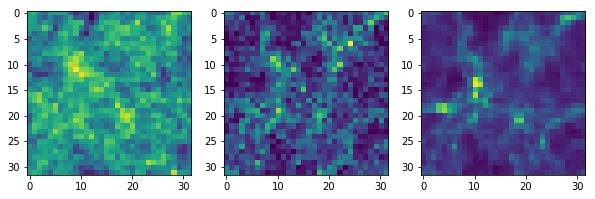

In [8]:
plt.figure(figsize = (10, 4))
ax = plt.subplot(1, 3, 1)
plt.imshow(s.sum(axis=0))
ax = plt.subplot(1, 3, 2)
plt.imshow(p.sum(axis=0))
ax = plt.subplot(1, 3, 3)
plt.imshow(d.sum(axis=0))

In [9]:
lins, fins, finsample = [], [], []
for seed in range(1000):
    lins.append(np.load(path.format(seed)+'s.npy'))
    fins.append(np.load(path.format(seed)+'d.npy'))
    finsample.append(np.load(path.format(seed)+'p.npy'))

lins = np.array(lins)
fins = np.array(fins)
finsample = np.array(finsample)

In [10]:
lins.shape, fins.shape, finsample.shape

((1000, 32, 32, 32), (1000, 32, 32, 32), (1000, 32, 32, 32))

In [11]:
inits = lins.copy()

In [12]:

def evolvefinal( xinit):
    tf.reset_default_graph()

    xrecon = tf.get_variable('xrecon',
                             initializer=xinit, 
                             trainable=True)

    icstate = tfpm.lptinit(xrecon, config, name='icstate')
    fnstate = tfpm.nbody(icstate, config, verbose=False, name='fnstate')
    final = tf.zeros_like(xrecon)
    final = tfpf.cic_paint(final, fnstate[0], boxsize=config['boxsize'], name='final')
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sample = sess.run(final)
    return sample



# Module

In [13]:

tf.reset_default_graph()


nfilter = 16
def module_fn():
    '''Define network here'''
    x = tf.placeholder(tf.float32, shape=[None, nc, nc, nc], name='input')
    y = tf.placeholder(tf.float32, shape=[None, nc, nc, nc], name='output')

    reg = tf.contrib.layers.l2_regularizer(0.00)

    xx = tf.expand_dims(x, -1)
    net = tf.layers.conv3d(xx,nfilter, 5, activation=tf.nn.leaky_relu, kernel_regularizer=reg,padding='same')
    
    net = tf.nn.leaky_relu(net)
    subnet = tf.layers.conv3d(net,nfilter, 3, kernel_regularizer=reg,padding='same')
    net = net + tf.layers.conv3d(subnet,nfilter, 3, kernel_regularizer=reg,padding='same')
    net = tf.nn.dropout(net, 0.95)

    net = tf.nn.leaky_relu(net)
    subnet = tf.layers.conv3d(net,nfilter, 3, kernel_regularizer=reg,padding='same')
    net = net + tf.layers.conv3d(subnet,nfilter, 3, kernel_regularizer=reg,padding='same')
    net = tf.nn.dropout(net, 0.95)

    net = tf.nn.leaky_relu(net)
    subnet = tf.layers.conv3d(net,nfilter, 3, kernel_regularizer=reg,padding='same')
    net = net + tf.layers.conv3d(subnet,nfilter, 3, kernel_regularizer=reg,padding='same')
    net = tf.nn.dropout(net, 0.95)

    net = tf.nn.leaky_relu(net)
    subnet = tf.layers.conv3d(net,nfilter, 3, kernel_regularizer=reg,padding='same')
    net = net + tf.layers.conv3d(subnet,nfilter, 3, kernel_regularizer=reg,padding='same')
    net = tf.nn.dropout(net, 0.95)

    net = tf.layers.conv3d(net,1, 3, activation=tf.nn.leaky_relu, kernel_regularizer=reg,padding='same')
    net = tf.layers.conv3d(net,1, 1, kernel_regularizer=reg,padding='same')

    lognet = tf.layers.conv3d(net, 1, 1, kernel_regularizer=reg,padding='same', 
                              name='lograte')    
    net = tf.nn.softplus(lognet)
    net= tf.squeeze(net)
    net = tf.identity(net, name='rate')
    mixture_dist = tfd.Poisson(rate=net)
    sample = tf.squeeze(mixture_dist.sample())
#     loglik = mixture_dist.log_prob(tf.expand_dims(y, -1))
    loglik = mixture_dist.log_prob(y)
    
    
    hub.add_signature(inputs={'features':x, 'labels':y}, 
#                           outputs={'sample':sample, 'loglikelihood':loglik, 'loc':loc, 
#                                   'scale':scale, 'logits':logits})
                        outputs={'sample':sample, 'loglikelihood':loglik, 'lograte':lognet, 'rate':net})
    
#####                                                                                                                                                                                                                                                                                     


spec = hub.create_module_spec(module_fn)
module = hub.Module(spec, trainable=True)


xx = tf.placeholder(tf.float32, shape=[None, nc, nc, nc], name='input')
yy = tf.placeholder(tf.float32, shape=[None, nc, nc, nc], name='input')
rate = module({'features':xx, 'labels':yy}, as_dict=True)['rate']
loglik = module({'features':xx, 'labels':yy}, as_dict=True)['loglikelihood']
sample = module({'features':xx, 'labels':yy}, as_dict=True)['sample']
loss = -loglik #tf.reduce_sum(tf.square(tf.add(rate, -yy)), axis=-1)
loss = tf.reduce_mean(loss)

lr = tf.placeholder(tf.float32)
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
losses =[]

data_size = 800
batch_size = 32

inds = np.random.randint(0, data_size, batch_size)
x = inits[inds]
y = finsample[inds]

# for i in range(500):
#     inds = np.random.randint(0, data_size, batch_size)
#     x = inits[inds]
#     y = finsample[inds]
#     l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.001})
#     if np.isnan(l): 
#         print(i, l)
#         break
#     losses.append( l)   
#     if i%300 ==0: print(l)
# for i in range(500):
#     inds = np.random.randint(0, data_size, batch_size)
#     x = inits[inds]
#     y = finsample[inds]
#     l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.0005})
#     if np.isnan(l): 
#         print(i, l)
#         break
#     losses.append(l)
#     if i%300 ==0: print(l)
# for i in range(500):
#     inds = np.random.randint(0, data_size, batch_size)
#     x = inits[inds]
#     y = finsample[inds]
#     l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.0001})
#     if np.isnan(l): 
#         print(i, l)
#         break
#     losses.append(l)
#     if i%300 ==0: print(l)
        
# learn = sess.run(sample, feed_dict={xx:inits, yy:y})
# learnrate = sess.run(rate, feed_dict={xx:inits, yy:y})

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [12]:
# modname = './modules/densemoduleza3dsample'
# module = hub.Module(modname, trainable=False)
# sample = module({'features':lins, 'labels':finsample}, as_dict=True)['sample']
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     learn = sess.run(sample)


INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


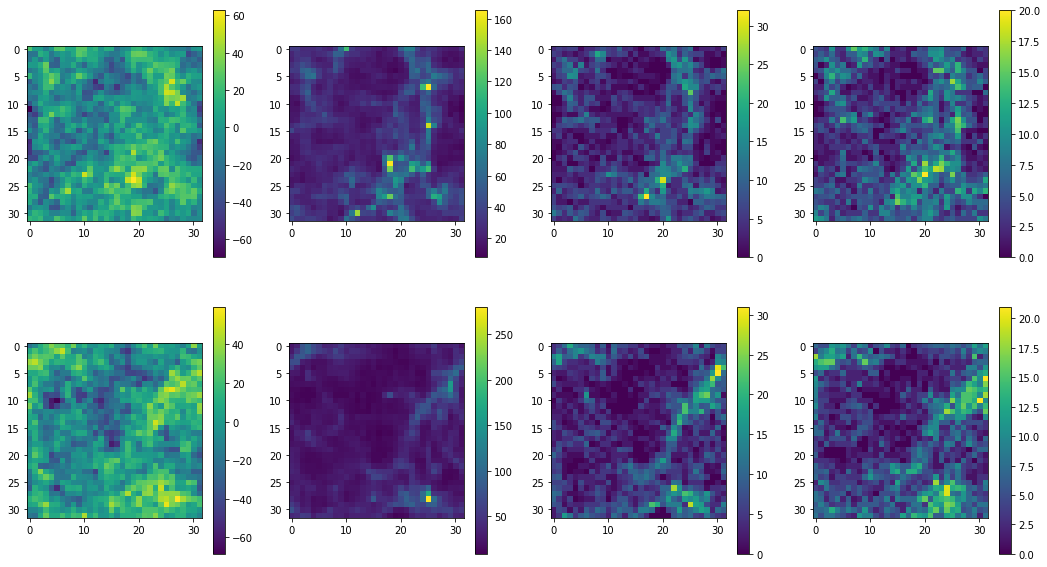

In [13]:
# plot(losses[1:])
# plt.yscale('log')
# plt.xscale('log')
# plt.show()


fig, ax = plt.subplots(2, 4, figsize = (18, 10))
ii = 90
axis = ax[0]
im = axis[0].imshow(inits[ii].sum(axis=0))
colorbar(im, ax=axis[0])
im = axis[1].imshow(fins[ii].sum(axis=0))
colorbar(im, ax=axis[1])
im = axis[2].imshow(finsample[ii].sum(axis=0))
colorbar(im, ax=axis[2])
im = axis[3].imshow(learn[ii].sum(axis=0))
colorbar(im, ax=axis[3])
ii = 900
axis = ax[1]
im = axis[0].imshow(inits[ii].sum(axis=0))
colorbar(im, ax=axis[0])
im = axis[1].imshow(fins[ii].sum(axis=0))
colorbar(im, ax=axis[1])
im = axis[2].imshow(finsample[ii].sum(axis=0))
colorbar(im, ax=axis[2])
im = axis[3].imshow(learn[ii].sum(axis=0))
colorbar(im, ax=axis[3])


In [91]:
%%bash
ls modules/
# rm -r ./modules/densemoduleza3dsample


densemodule
densemoduleza
densemoduleza2d
densemodulezanormal
densemodulezapoisson
fwdmodel
fwdmodelza2d
specdensemodule
specdensemoduleza
specdensemodulezanormal
specdensemodulezapoisson
testspecnorm
testspecnormfalse
testvanillanorm


In [41]:
module.export('./modules/densemoduleza3dsample', sess)


INFO:tensorflow:Exported TF-Hub module to: ./modules/densemoduleza3dsample


In [16]:

ir = [900]


In [199]:
tf.reset_default_graph()
modname = './modules/densemoduleza3dsample///'
module = hub.Module(modname, trainable=False)
sample = module({'features':inits, 'labels':finsample}, as_dict=True)['sample']
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    learn = sess.run(sample)
#     learn = sess.run(sample, feed_dict={xx:inits, yy:finsample})


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


# Reconstruct here

In [18]:


def dorecon(yy, xinit, modname, useprior=True, niter=5000, lr=0.001, sampleonly=False):
    tf.reset_default_graph()
    module = hub.Module(modname, trainable=False)

    xrecon = tf.get_variable('xrecon',
                             initializer=xinit, 
                             trainable=True)

    sample = module({'features':xrecon, 'labels':yy}, as_dict=True)['sample']
    if sampleonly: 
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            sample = sess.run(sample)
        return sample
    loglik = module({'features':xrecon, 'labels':yy}, as_dict=True)['loglikelihood']
    loglik = -tf.reduce_sum(loglik, axis=(1, 2, 3))
    
    xreconk = tfpf.r2c3d(xrecon)
    priormesh = tf.square(tf.cast(tf.abs(xreconk), tf.float32))
    prior = tf.reduce_sum(tf.multiply(priormesh, 1/priorwt), axis=(1, 2, 3))
    prior = tf.multiply(prior, 1/nc, name='prior')
    print(loglik, prior)

    if useprior: loss = tf.add(loglik, prior)
    else: loss = loglik
#   
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
    opt_op = optimizer.minimize(loss, var_list=[xrecon])


    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        xinit = sess.run(xrecon)
        losses = []
        priors = []
        for it in range(niter+1):
            _, l, p = sess.run([opt_op, loss, prior])
            if it%300==0: print(it, l[0])
            losses.append(l)
            priors.append(p)
        xfin = sess.run(xrecon)
        
    return xfin, losses, priors


In [22]:
tf.reset_default_graph()
modname = './modules/densemoduleza3dsample///'
xrecons = []
losses = []
priors = []
xinit = []

nstart = 10

for ii in ir:
#     ii = 2*i
    np.random.seed(100)
    yy = np.array([finsample[ii].copy() for j in range(nstart)])
    yy = yy
    xi = 1*randn(nstart, nc, nc, nc)
    xi = xi.astype('float32')
    recons = dorecon(yy, xi, modname, useprior=True, niter=5000, lr=0.01)
    xrecon = np.squeeze(recons[0])
    xrecons.append(xrecon)
    losses.append(np.squeeze(recons[1]))
    priors.append(np.squeeze(recons[2]))
    xinit.append(xi)



INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Tensor("Neg:0", shape=(10,), dtype=float32) Tensor("prior:0", shape=(10,), dtype=float32)
17805.09
10921.175
10448.428
10226.298
10056.627
9969.294
9883.492
9816.85
9731.231
9704.063
9630.973
9604.92
9545.508
9537.767
9491.891
9456.191
9438.099


In [19]:
# np.save('./xrecondenseza3dsample', xrecon)
xrecons = [np.load('./xrecondenseza3dsample.npy')]

In [20]:
ii = 0
plt.plot(losses[0][:, ii])
plt.plot(priors[0][:, ii])
plt.yscale('log')
plt.xscale('log')


NameError: name 'losses' is not defined

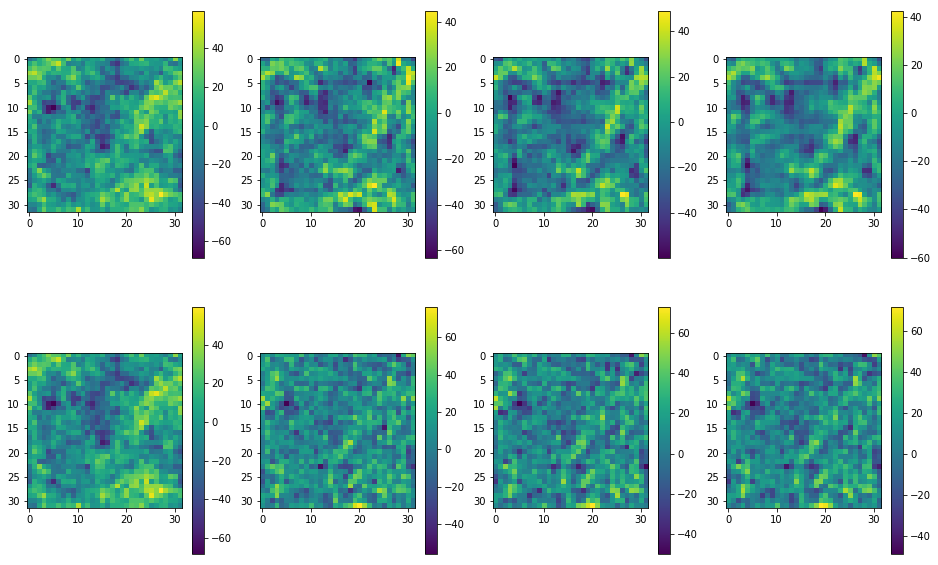

In [21]:
fig, axar = plt.subplots(2,4,figsize=(16, 10))

ax = axar[0]
im = ax[0].imshow(inits[ir[0]].sum(axis=0))
colorbar(im, ax=ax[0])
im = ax[1].imshow(xrecons[0][0].sum(axis=0))
colorbar(im, ax=ax[1])
im = ax[2].imshow(xrecons[0][5].sum(axis=0))
colorbar(im, ax=ax[2])
im = ax[3].imshow(xrecons[0].mean(axis=0).sum(axis=0))
colorbar(im, ax=ax[3])

ax = axar[1]
im = ax[0].imshow(inits[ir[0]].sum(axis=0))
colorbar(im, ax=ax[0])
im = ax[1].imshow((inits[ir[0]]-xrecons[0][0]).sum(axis=0))
colorbar(im, ax=ax[1])
im = ax[2].imshow((inits[ir[0]]-xrecons[0][5]).sum(axis=0))
colorbar(im, ax=ax[2])
im = ax[3].imshow((inits[ir[0]]-xrecons[0].mean(axis=0)).sum(axis=0))
colorbar(im, ax=ax[3])


/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


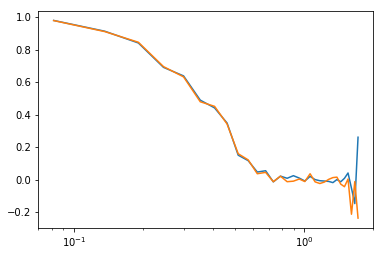

In [22]:
kk, p1 = tools.power(inits[ir[0]], boxsize=bs)
kk, p2 = tools.power(xrecons[0][0], boxsize=bs)
kk, p12 = tools.power(inits[ir[0]], xrecons[0][0], boxsize=bs)
kk, p2all = tools.power(xrecons[0].mean(axis=0), boxsize=bs)
kk, p12all = tools.power(inits[ir[0]], xrecons[0].mean(axis=0), boxsize=bs)

plt.plot(kk, p12/(p1*p2)**0.5)
plt.plot(kk, p12all/(p1*p2all)**0.5)
plt.xscale('log')

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


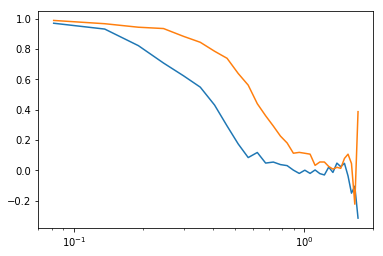

In [23]:
modname = './modules/densemoduleza3dsample///'
samplexrecons = dorecon(xrecons[0]*0, xrecons[0], modname=modname, sampleonly=True)

tmp = np.expand_dims(inits[ir[0]], 0)
samplelearn = dorecon(tmp*0, tmp , modname=modname, sampleonly=True)


kk, p1 = tools.power(finsample[ir[0]], boxsize=bs)
kk, p2 = tools.power(samplelearn, boxsize=bs)
kk, p12 = tools.power(finsample[ir[0]], samplelearn, boxsize=bs)
kk, p2r = tools.power(samplexrecons[0], boxsize=bs)
kk, p12r = tools.power(finsample[ir[0]], samplexrecons[0], boxsize=bs)

plt.plot(kk, p12/(p1*p2)**0.5)
plt.plot(kk, p12r/(p1*p2r)**0.5)
plt.xscale('log')

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


# Train model on final field

In [22]:

tf.reset_default_graph()


nfilter = 16
def module_fn():
    '''Define network here'''
    x = tf.placeholder(tf.float32, shape=[None, nc, nc, nc], name='input')
    y = tf.placeholder(tf.float32, shape=[None, nc, nc, nc], name='output')

    reg = tf.contrib.layers.l2_regularizer(0.00)

    xx = tf.expand_dims(x, -1)
    net = tf.layers.conv3d(xx,nfilter, 5, activation=tf.nn.leaky_relu, kernel_regularizer=reg,padding='same')
    
    net = tf.nn.leaky_relu(net)
    subnet = tf.layers.conv3d(net,nfilter, 3, kernel_regularizer=reg,padding='same')
    net = net + tf.layers.conv3d(subnet,nfilter, 3, kernel_regularizer=reg,padding='same')
    net = tf.nn.dropout(net, 0.95)

    net = tf.nn.leaky_relu(net)
    subnet = tf.layers.conv3d(net,nfilter, 3, kernel_regularizer=reg,padding='same')
    net = net + tf.layers.conv3d(subnet,nfilter, 3, kernel_regularizer=reg,padding='same')
    net = tf.nn.dropout(net, 0.95)

    net = tf.nn.leaky_relu(net)
    subnet = tf.layers.conv3d(net,nfilter, 3, kernel_regularizer=reg,padding='same')
    net = net + tf.layers.conv3d(subnet,nfilter, 3, kernel_regularizer=reg,padding='same')
    net = tf.nn.dropout(net, 0.95)

    net = tf.nn.leaky_relu(net)
    subnet = tf.layers.conv3d(net,nfilter, 3, kernel_regularizer=reg,padding='same')
    net = net + tf.layers.conv3d(subnet,nfilter, 3, kernel_regularizer=reg,padding='same')
    net = tf.nn.dropout(net, 0.95)

    net = tf.layers.conv3d(net,1, 3, activation=tf.nn.leaky_relu, kernel_regularizer=reg,padding='same')
    net = tf.layers.conv3d(net,1, 1, kernel_regularizer=reg,padding='same')

    lognet = tf.layers.conv3d(net, 1, 1, kernel_regularizer=reg,padding='same', 
                              name='lograte')    
    net = tf.nn.softplus(lognet)
    net= tf.squeeze(net)
    net = tf.identity(net, name='rate')
    mixture_dist = tfd.Poisson(rate=net)
    sample = tf.squeeze(mixture_dist.sample())
#     loglik = mixture_dist.log_prob(tf.expand_dims(y, -1))
    loglik = mixture_dist.log_prob(y)
    
    
    hub.add_signature(inputs={'features':x, 'labels':y}, 
#                           outputs={'sample':sample, 'loglikelihood':loglik, 'loc':loc, 
#                                   'scale':scale, 'logits':logits})
                        outputs={'sample':sample, 'loglikelihood':loglik, 'lograte':lognet, 'rate':net})
    
#####                                                                                                                                                                                                                                                                                     


spec = hub.create_module_spec(module_fn)
module = hub.Module(spec, trainable=True)


xx = tf.placeholder(tf.float32, shape=[None, nc, nc, nc], name='input')
yy = tf.placeholder(tf.float32, shape=[None, nc, nc, nc], name='input')
rate = module({'features':xx, 'labels':yy}, as_dict=True)['rate']
loglik = module({'features':xx, 'labels':yy}, as_dict=True)['loglikelihood']
sample = module({'features':xx, 'labels':yy}, as_dict=True)['sample']
loss = -loglik #tf.reduce_sum(tf.square(tf.add(rate, -yy)), axis=-1)
loss = tf.reduce_mean(loss)

lr = tf.placeholder(tf.float32)
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
losses =[]

data_size = 800
batch_size = 32

# for i in range(500):
#     inds = np.random.randint(0, data_size, batch_size)
#     x = fins[inds]
#     y = finsample[inds]
#     l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.002})
#     if np.isnan(l): 
#         print(i, l)
#         break
#     losses.append( l)   
#     if i%300 ==0: print(l)
# for i in range(500):
#     inds = np.random.randint(0, data_size, batch_size)
#     x = fins[inds]
#     y = finsample[inds]
#     l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.001})
#     if np.isnan(l): 
#         print(i, l)
#         break
#     losses.append(l)
#     if i%300 ==0: print(l)
# for i in range(500):
#     inds = np.random.randint(0, data_size, batch_size)
#     x = fins[inds]
#     y = finsample[inds]
#     l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.0005})
#     if np.isnan(l): 
#         print(i, l)
#         break
#     losses.append(l)
#     if i%300 ==0: print(l)
        
# print('Done', l)
# if ~np.isnan(l):
#     learnfin = sess.run(sample, feed_dict={xx:fins, yy:y})
#     learnfinrate = sess.run(rate, feed_dict={xx:fins, yy:y})

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


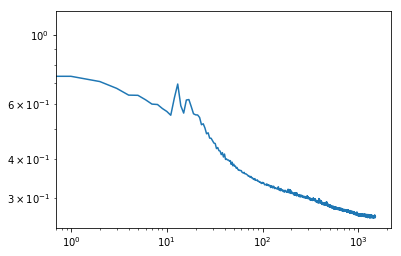

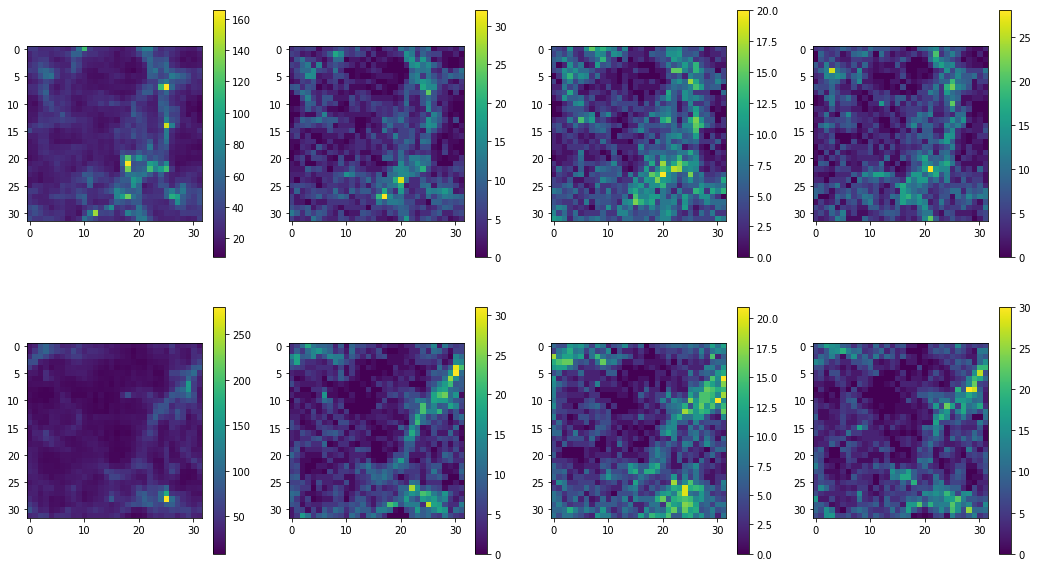

In [19]:
plot(losses[1:])
plt.yscale('log')
plt.xscale('log')
plt.show()


fig, ax = plt.subplots(2, 4, figsize = (18, 10))
ii = 90
axis = ax[0]
im = axis[0].imshow(fins[ii].sum(axis=0))
colorbar(im, ax=axis[0])
im = axis[1].imshow(finsample[ii].sum(axis=0))
colorbar(im, ax=axis[1])
im = axis[2].imshow(learn[ii].sum(axis=0))
colorbar(im, ax=axis[2])
im = axis[3].imshow(learnfin[ii].sum(axis=0))
colorbar(im, ax=axis[3])
ii = 900
axis = ax[1]
im = axis[0].imshow(fins[ii].sum(axis=0))
colorbar(im, ax=axis[0])
im = axis[1].imshow(finsample[ii].sum(axis=0))
colorbar(im, ax=axis[1])
im = axis[2].imshow(learn[ii].sum(axis=0))
colorbar(im, ax=axis[2])
im = axis[3].imshow(learnfin[ii].sum(axis=0))
colorbar(im, ax=axis[3])


In [22]:
%%bash
ls modules/
rm -r ./modules/densemoduleza3dsamplefin


densemodule
densemoduleza
densemoduleza2d
densemoduleza2dsample
densemoduleza3dsample
densemoduleza3dsamplefin
densemodulezanormal
densemodulezapoisson
fwdmodel
fwdmodelza2d
specdensemodule
specdensemoduleza
specdensemoduleza2d
specdensemoduleza2dsample
specdensemodulezanormal
specdensemodulezapoisson
testspecnorm
testspecnormfalse
testvanillanorm


In [23]:
module.export('./modules/densemoduleza3dsamplefin', sess)


INFO:tensorflow:Exported TF-Hub module to: ./modules/densemoduleza3dsamplefin


In [198]:
tf.reset_default_graph()
modname = './modules/densemoduleza3dsamplefin///'
module = hub.Module(modname, trainable=False)
sample = module({'features':fins, 'labels':finsample}, as_dict=True)['sample']
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    learnfin = sess.run(sample)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


### Reconstruct with fin model

In [14]:
kmesh = sum(kk**2 for kk in config['kvec'])**0.5
priorwt = config['ipklin'](kmesh) * config['boxsize'] ** -3

def doreconfin(yy, xinit, modname, useprior=True, niter=5000, lr=0.001, sampleonly=False):
    tf.reset_default_graph()
    module = hub.Module(modname, trainable=False)

    xrecon = tf.get_variable('xrecon',
                             initializer=xinit, 
                             trainable=True)

    icstate = tfpm.lptinit(xrecon, config, name='icstate')
    fnstate = tfpm.nbody(icstate, config, verbose=False, name='fnstate')
    final = tf.zeros_like(xrecon)
    final = tfpf.cic_paint(final, fnstate[0], boxsize=config['boxsize'], name='final')

    sample = module({'features':tf.expand_dims(final, 0), 'labels':yy}, as_dict=True)['sample']
    if sampleonly: 
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            sample = sess.run(sample)
        return sample
    
        
    loglik = module({'features':tf.expand_dims(final, 0), 'labels':yy}, as_dict=True)['loglikelihood']
    loglik = -tf.reduce_sum(loglik, axis=(1, 2, 3))
    
    xreconk = tfpmfuncs.r2c3d(xrecon)
    priormesh = tf.square(tf.cast(tf.abs(xreconk), tf.float32))
    prior = tf.reduce_sum(tf.multiply(priormesh, 1/priorwt), axis=(0, 1, 2))
    prior = tf.multiply(prior, 1/nc, name='prior')
    print(loglik, prior)

    if useprior: loss = tf.add(loglik, prior)
    else: loss = loglik
#   
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
    opt_op = optimizer.minimize(loss, var_list=[xrecon])


    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        xinit = sess.run(xrecon)
        losses = []
        priors = []
        for it in range(niter+1):
            _, l, p = sess.run([opt_op, loss, prior])
            if it%300==0: print(it, l[0])
            losses.append(l)
            priors.append(p)
        xfin = sess.run(xrecon)
        
    return xfin, losses, priors

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  """Entry point for launching an IPython kernel.


In [42]:
tf.reset_default_graph()
modname = './modules/densemoduleza3dsamplefin/'
xreconsfin = []
losses = []
priors = []
xinit = []

nstart = 1

ir = [900]
for ii in ir:
#     ii = 2*i
    np.random.seed(100)
    yy = np.array([finsample[ii].copy() for j in range(nstart)])
    yy = yy
    xi = 1*randn( nc, nc, nc)
    xi = xi.astype('float32')
#     xi = xreconsfin[0].copy()

    recons = doreconfin(yy, xi, modname, useprior=True, niter=8000, lr=0.01)
    xrecon = np.squeeze(recons[0])
    xreconsfin.append(xrecon)
    losses.append(np.squeeze(recons[1]))
    priors.append(np.squeeze(recons[2]))
    xinit.append(xi)



INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Tensor("Neg:0", shape=(1,), dtype=float32) Tensor("prior:0", shape=(), dtype=float32)
27936.836
7541.4644
7135.473
6973.9834
6861.3145
6766.371
6696.9014
6652.6396
6635.123
6611.8154
6594.299
6575.9336
6559.123
6538.08
6555.9893
6540.07
6533.2783
6529.7285
6525.0635
6527.927
6530.088
6520.6426
6511.0083
6506.644
6517.9883
6506.3853
6509.262


In [419]:
# tf.reset_default_graph()
# modname = './modules/densemoduleza3dsamplefin/'
# xreconsfintrue = []
# losses = []
# priors = []
# xinit = []

# nstart = 1

# ir = [900]
# for ii in ir:
# #     ii = 2*i
#     np.random.seed(100)
#     yy = np.array([finsample[ii].copy() for j in range(nstart)])
#     yy = yy
#     xi = lins[ir[0]].copy()
#     xi = xi.astype('float32')
# #     xi = xreconsfin[0].copy()

#     recons = doreconfin(yy, xi, modname, useprior=True, niter=8000, lr=0.01)
#     xrecon = np.squeeze(recons[0])
#     xreconsfintrue.append(xrecon)
#     losses.append(np.squeeze(recons[1]))
#     priors.append(np.squeeze(recons[2]))
#     xinit.append(xi)



INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Tensor("Neg:0", shape=(1,), dtype=float32) Tensor("prior:0", shape=(), dtype=float32)
9746.857
8573.65
8205.66
7996.4663
7822.5513
7698.8975
7600.873
7517.6167
7446.5854
7382.6895
7327.3174
7289.403
7265.509
7216.6665
7189.422
7169.156
7158.4937
7147.092
7113.278
7103.2925
7092.515
7066.162
7072.3135
7038.8535
7058.521
7038.4004
7047.43


In [24]:
# np.save('./xreconfindenseza3dsample', xreconsfin[0])
# xreconsfin = [np.load('./xreconfindenseza3dsample.npy')]

In [ ]:
# for ii in ir:
# #     ii = 2*i
#     xi = xreconsfin[0].copy()
#     recons = doreconfin(yy, xi, modname, useprior=True, niter=5000, lr=0.01)
#     xrecon = np.squeeze(recons[0])
#     xreconsfin.append(xrecon)
#     losses.append(np.squeeze(recons[1]))
#     priors.append(np.squeeze(recons[2]))
#     xinit.append(xi)



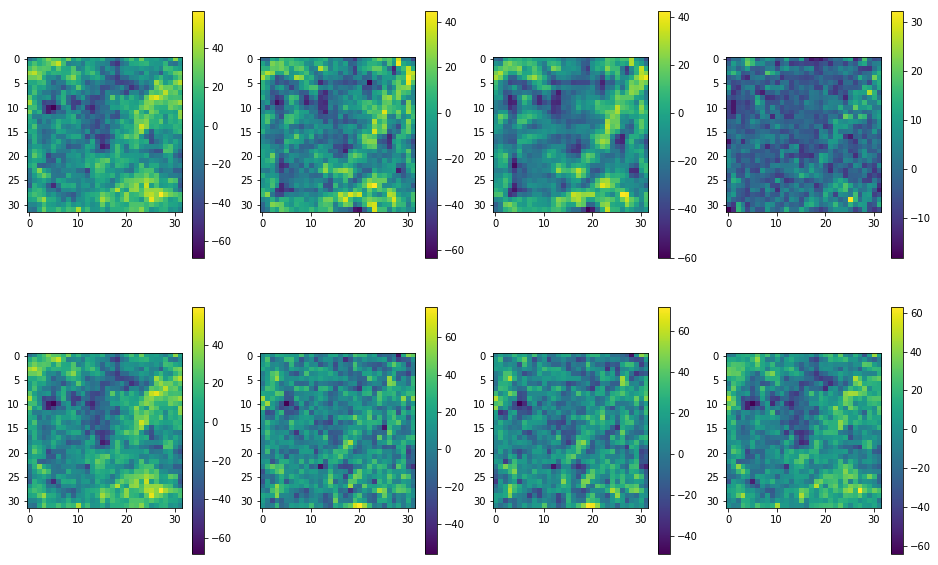

In [25]:
fig, axar = plt.subplots(2,4,figsize=(16, 10))

ax = axar[0]
im = ax[0].imshow(inits[ir[0]].sum(axis=0))
colorbar(im, ax=ax[0])
im = ax[1].imshow(xrecons[0][0].sum(axis=0))
colorbar(im, ax=ax[1])
im = ax[2].imshow(xrecons[0].mean(axis=0).sum(axis=0))
colorbar(im, ax=ax[2])
im = ax[3].imshow(xreconsfin[-1].sum(axis=0))
colorbar(im, ax=ax[3])

ax = axar[1]
im = ax[0].imshow(inits[ir[0]].sum(axis=0))
colorbar(im, ax=ax[0])
im = ax[1].imshow((inits[ir[0]]-xrecons[0][0]).sum(axis=0))
colorbar(im, ax=ax[1])
im = ax[2].imshow((inits[ir[0]]-xrecons[0].mean(axis=0)).sum(axis=0))
colorbar(im, ax=ax[2])
im = ax[3].imshow((inits[ir[0]]-xreconsfin[-1]).sum(axis=0))
colorbar(im, ax=ax[3])


In [59]:
# fig, axar = plt.subplots(2,4,figsize=(16, 10))

# ax = axar[0]
# im = ax[0].imshow(inits[ir[0]].sum(axis=0))
# colorbar(im, ax=ax[0])
# im = ax[1].imshow(xrecons[0][0].sum(axis=0))
# colorbar(im, ax=ax[1])
# im = ax[2].imshow(xrecons[0].mean(axis=0).sum(axis=0))
# colorbar(im, ax=ax[2])
# im = ax[3].imshow(xreconsfintrue[-1].sum(axis=0))
# colorbar(im, ax=ax[3])

# ax = axar[1]
# im = ax[0].imshow(inits[ir[0]].sum(axis=0))
# colorbar(im, ax=ax[0])
# im = ax[1].imshow((inits[ir[0]]-xrecons[0][0]).sum(axis=0))
# colorbar(im, ax=ax[1])
# im = ax[2].imshow((inits[ir[0]]-xrecons[0].mean(axis=0)).sum(axis=0))
# colorbar(im, ax=ax[2])
# im = ax[3].imshow((inits[ir[0]]-xreconsfintrue[-1]).sum(axis=0))
# colorbar(im, ax=ax[3])


In [439]:
# np.save('./xreconfintruedenseza3dsample', xreconsfintrue[0])
# xreconsfintrue = [np.load('./xreconfintruedenseza3dsample.npy')]

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


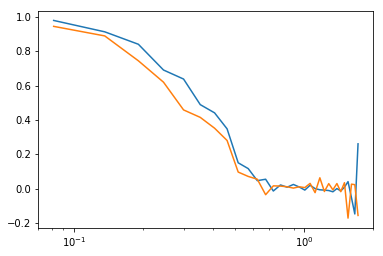

In [27]:
kk, p1 = tools.power(inits[ir[0]], boxsize=bs)
kk, p2 = tools.power(xrecons[0][0], boxsize=bs)
kk, p12 = tools.power(inits[ir[0]], xrecons[0][0], boxsize=bs)
kk, p2all = tools.power(xreconsfin[-1], boxsize=bs)
kk, p12all = tools.power(inits[ir[0]], xreconsfin[-1], boxsize=bs)
# kk, p2true = tools.power(xreconsfintrue[-1], boxsize=bs)
# kk, p12true = tools.power(inits[ir[0]], xreconsfintrue[-1], boxsize=bs)

plt.plot(kk, p12/(p1*p2)**0.5)
plt.plot(kk, p12all/(p1*p2all)**0.5)
# plt.plot(kk, p12true/(p1*p2true)**0.5, '--')
plt.xscale('log')

In [28]:
tf.reset_default_graph()
modname = './modules/densemoduleza3dsamplefin/'
samplexreconsfin = doreconfin(np.expand_dims(xreconsfin[-1], axis=0)*0, xreconsfin[-1], modname=modname,  sampleonly=True)

tmp = inits[ir[0]].copy()
samplelearnfin = doreconfin(np.expand_dims(tmp, 0)*0, tmp , modname=modname, sampleonly=True)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


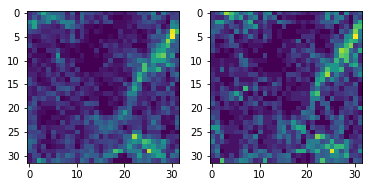

In [29]:
ax = plt.subplot(1, 2, 1)
plt.imshow(finsample[ir[0]].sum(axis=0))
ax = plt.subplot(1, 2, 2)
plt.imshow(samplexreconsfin.sum(axis=0))

# Custom dense layer

In [30]:
tf.glorot_normal_initializer()

In [230]:
import sys
sys.path.append('../../utils/')
import tfops, layers
from layers import SpecDenseLayer
from tfops import specnormconv3d as specconv3d


#####                                                                                                                                                                                                                                                                                     

tf.reset_default_graph()

nfilter = 16
num_iters = 1
def module_fn():
    '''Define network here'''
    x = tf.placeholder(tf.float32, shape=[None, nc, nc, nc], name='input')
    y = tf.placeholder(tf.float32, shape=[None, nc, nc, nc], name='output')

    xx = tf.expand_dims(x, -1)

    net = specconv3d(xx, nfilter, 5, num_iters=num_iters)
    net = activation=tf.nn.leaky_relu(net)

    net = tf.nn.leaky_relu(net)
    subnet = specconv3d(net, nfilter, 3, name='l11', num_iters=num_iters)
    net = net + specconv3d(subnet,nfilter, 3, name='l12', num_iters=num_iters)
    net = tf.nn.dropout(net, 0.95)

    net = tf.nn.leaky_relu(net)
    subnet = specconv3d(net, nfilter, 3, name='l21', num_iters=num_iters)
    net = net + specconv3d(subnet,nfilter, 3, name='l22', num_iters=num_iters)
    net = tf.nn.dropout(net, 0.95)

    net = tf.nn.leaky_relu(net)
    subnet = specconv3d(net, nfilter, 3, name='l31', num_iters=num_iters)
    net = net + specconv3d(subnet,nfilter, 3, name='l32', num_iters=num_iters)
    net = tf.nn.dropout(net, 0.95)

    net = tf.nn.leaky_relu(net)
    subnet = specconv3d(net, nfilter, 3, name='l41', num_iters=num_iters)
    net = net + specconv3d(subnet,nfilter, 3, name='l42', num_iters=num_iters)
    net = tf.nn.dropout(net, 0.95)

    net = specconv3d(net,1, 3, name='l51', num_iters=num_iters)
    net = tf.nn.leaky_relu(net)
    net = specconv3d(net,1, 1, name='l61', num_iters=num_iters)

    lognet = specconv3d(net, 1, 1, name='l61', num_iters=num_iters)
    
    net = tf.nn.softplus(lognet)
    net= tf.squeeze(net)
    net = tf.identity(net, name='rate')
    mixture_dist = tfd.Poisson(rate=net)
    sample = tf.squeeze(mixture_dist.sample())
#     loglik = mixture_dist.log_prob(tf.expand_dims(y, -1))
    loglik = mixture_dist.log_prob(y)
    
    
    hub.add_signature(inputs={'features':x, 'labels':y}, 
#                           outputs={'sample':sample, 'loglikelihood':loglik, 'loc':loc, 
#                                   'scale':scale, 'logits':logits})
                        outputs={'sample':sample, 'loglikelihood':loglik, 'lograte':lognet, 'rate':net})
    
    
#####                                                                                                                                                                                                                                                                                     


spec = hub.create_module_spec(module_fn)
module = hub.Module(spec, trainable=True)


xx = tf.placeholder(tf.float32, shape=[None, nc, nc, nc], name='input')
yy = tf.placeholder(tf.float32, shape=[None, nc, nc, nc], name='input')
rate = module({'features':xx, 'labels':yy}, as_dict=True)['rate']
loglik = module({'features':xx, 'labels':yy}, as_dict=True)['loglikelihood']
sample = module({'features':xx, 'labels':yy}, as_dict=True)['sample']
loss = loglik#tf.reduce_sum(tf.square(tf.add(rate, -yy)), axis=-1)
loss = -tf.reduce_mean(loss)

lr = tf.placeholder(tf.float32)
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
losses =[]



data_size = 800
batch_size = 32

for i in range(500):
    inds = np.random.randint(0, data_size, batch_size)
    x = inits[inds]
    y = finsample[inds]
    l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.001})
    if np.isnan(l): print(i, l)
    losses.append(l)
    if i%300 ==0: print(l)
for i in range(500):
    inds = np.random.randint(0, data_size, batch_size)
    x = inits[inds]
    y = finsample[inds]
    l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.001})
    if np.isnan(l): print(i, l)
    losses.append(l)
    if i%300 ==0: print(l)
for i in range(500):
    inds = np.random.randint(0, data_size, batch_size)
    x = inits[inds]
    y = finsample[inds]
    l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.0001})
    if np.isnan(l): print(i, l)
    losses.append(l)
    if i%300 ==0: print(l)

        
        
learnspec = sess.run(sample, feed_dict={xx:inits, yy:y})
learnspecrate = sess.run(rate, feed_dict={xx:inits, yy:y})


../../utils/tfops.py:35: UserWarning: Setting update_collection to None will make u being updated every W execution. This maybe undesirable. Please consider using a update collection instead.
  warnings.warn('Setting update_collection to None will make u being updated every W execution. This maybe undesirable'
../../utils/tfops.py:35: UserWarning: Setting update_collection to None will make u being updated every W execution. This maybe undesirable. Please consider using a update collection instead.
  warnings.warn('Setting update_collection to None will make u being updated every W execution. This maybe undesirable'
../../utils/tfops.py:35: UserWarning: Setting update_collection to None will make u being updated every W execution. This maybe undesirable. Please consider using a update collection instead.
  warnings.warn('Setting update_collection to None will make u being updated every W execution. This maybe undesirable'
../../utils/tfops.py:35: UserWarning: Setting update_collection 

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
0.66088754
0.3933733
0.3798633
0.37381434
0.37135574
0.36796284


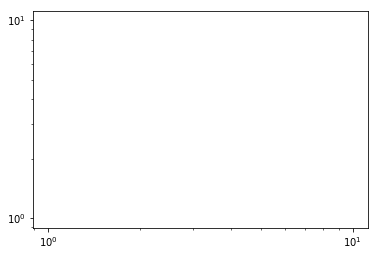

IndexError: index 90 is out of bounds for axis 0 with size 32

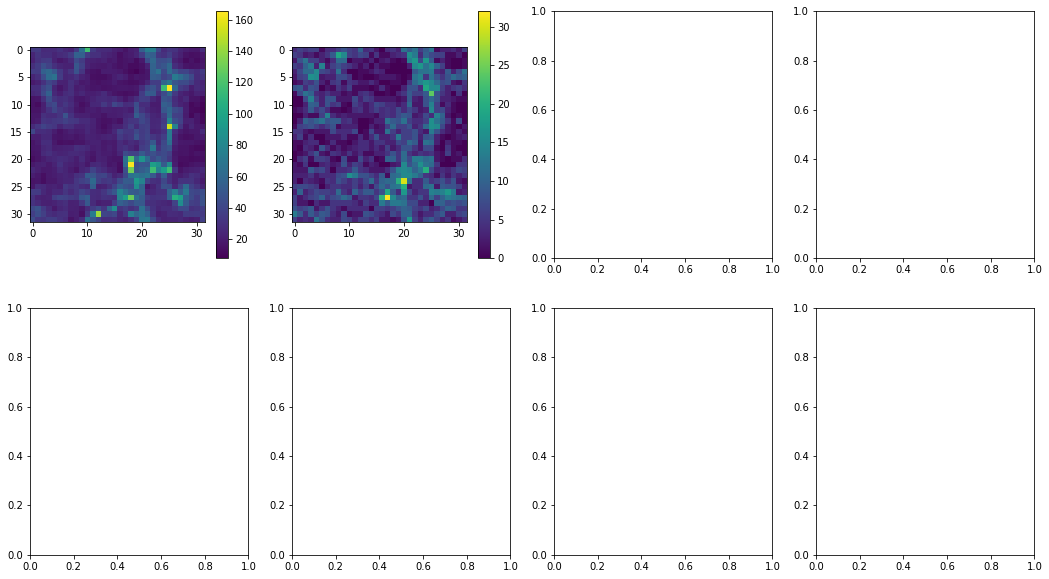

In [62]:
plot(losses[1:])
plt.yscale('log')
plt.xscale('log')
plt.show()


fig, ax = plt.subplots(2, 4, figsize = (18, 10))
ii = 90
axis = ax[0]
im = axis[0].imshow(fins[ii].sum(axis=0))
colorbar(im, ax=axis[0])

im = axis[1].imshow(finsample[ii].sum(axis=0))
colorbar(im, ax=axis[1])
im = axis[2].imshow(learn[ii].sum(axis=0))
colorbar(im, ax=axis[2])
im = axis[3].imshow(learnspec[ii].sum(axis=0))
colorbar(im, ax=axis[3])
ii = 900
axis = ax[1]
im = axis[0].imshow(fins[ii].sum(axis=0))
colorbar(im, ax=axis[0])
im = axis[1].imshow(finsample[ii].sum(axis=0))
colorbar(im, ax=axis[1])
im = axis[2].imshow(learn[ii].sum(axis=0))
colorbar(im, ax=axis[2])
im = axis[3].imshow(learnspec[ii].sum(axis=0))
colorbar(im, ax=axis[3])


In [87]:
%%bash
ls ./modules/
rm -r ./modules/specdensemoduleza3dsample


densemodule
densemoduleza
densemoduleza2d
densemoduleza2dsample
densemodulezanormal
densemodulezapoisson
fwdmodel
fwdmodelza2d
specdensemodule
specdensemoduleza
specdensemoduleza2d
specdensemoduleza2dsample
specdensemodulezanormal
specdensemodulezapoisson
testspecnorm
testspecnormfalse
testvanillanorm


In [232]:
module.export('./modules/specdensemoduleza3dsample', sess)


INFO:tensorflow:Exported TF-Hub module to: ./modules/specdensemoduleza3dsample


In [134]:
tf.reset_default_graph()
modname = './modules/specdensemoduleza3dsample///'
module = hub.Module(modname, trainable=False)
sample = module({'features':fins[ir[0]:ir[0]+1], 'labels':finsample[ir[0]:ir[0]+1]}, as_dict=True)['sample']
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    learnspec = sess.run(sample)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


## recon again 

In [55]:
tf.reset_default_graph()
modname = './modules/densemoduleza3dsample//'
xreconsspec = []
losses = []
priors = []
xinitspec = []

nstart = 50
ir = [900]

for ii in ir:
#     ii = 2*i
    np.random.seed(100)
    yy = np.array([finsample[ii].copy() for j in range(nstart)])
    yy = yy
    xi = 1*randn(nstart, nc, nc, nc)
    xi = xi.astype('float32')
    recons = dorecon(yy, xi, modname, useprior=True, niter=3000, lr=0.01)
    xrecon = np.squeeze(recons[0])
    xreconsspec.append(xrecon)
    losses.append(np.squeeze(recons[1]))
    priors.append(np.squeeze(recons[2]))
    xinitspec.append(xi)




INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Tensor("Neg:0", shape=(50,), dtype=float32) Tensor("prior:0", shape=(50,), dtype=float32)
17853.1
10878.453
10419.455
10181.928
10018.995
9895.865
9830.85
9745.063
9688.067
9628.121
9579.757


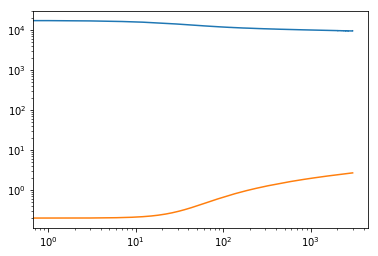

In [56]:
ii = 5
plt.plot(losses[0][:, ii])
plt.plot(priors[0][:, ii])
plt.yscale('log')
plt.xscale('log')
plt.show()


In [69]:
# np.save('./xreconspecdenseza3dsample', xreconsspec[0])
# xreconsspec = [np.load('./xreconspecdenseza3dsample.npy')]

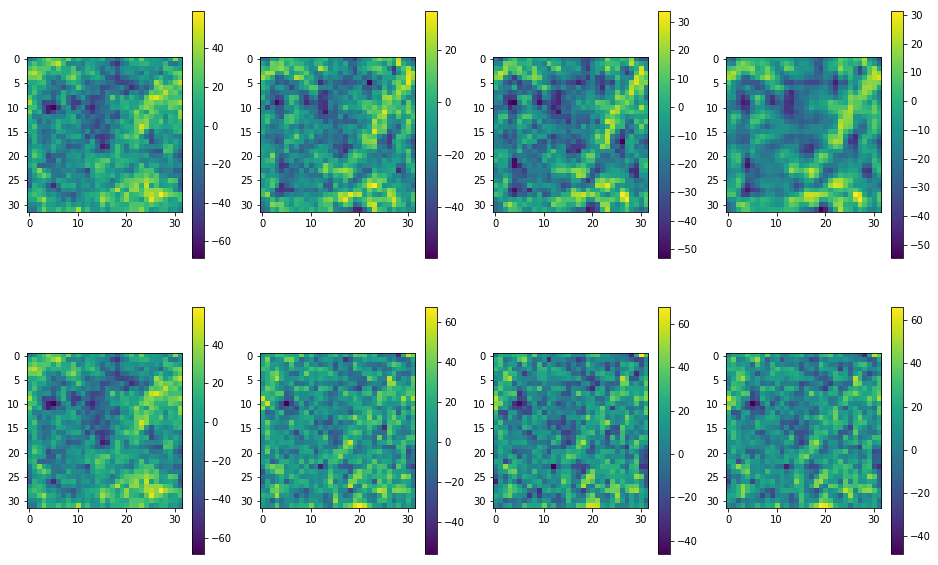

In [70]:
fig, axar = plt.subplots(2,4,figsize=(16, 10))

ax = axar[0]
im = ax[0].imshow(inits[ir[0]].sum(axis=0))
colorbar(im, ax=ax[0])
im = ax[1].imshow(xreconsspec[0][0].sum(axis=0))
colorbar(im, ax=ax[1])
im = ax[2].imshow(xreconsspec[0][25].sum(axis=0))
colorbar(im, ax=ax[2])
im = ax[3].imshow(xreconsspec[0].mean(axis=0).sum(axis=0))
colorbar(im, ax=ax[3])

ax = axar[1]
im = ax[0].imshow(inits[ir[0]].sum(axis=0))
colorbar(im, ax=ax[0])
im = ax[1].imshow((inits[ir[0]]-xreconsspec[0][0]).sum(axis=0))
colorbar(im, ax=ax[1])
im = ax[2].imshow((inits[ir[0]]-xreconsspec[0][25]).sum(axis=0))
colorbar(im, ax=ax[2])
im = ax[3].imshow((inits[ir[0]]-xreconsspec[0].mean(axis=0)).sum(axis=0))
colorbar(im, ax=ax[3])


In [71]:
modname = './modules/specdensemoduleza3dsample//'
samplexreconsspec = dorecon(xreconsspec[0]*0, xreconsspec[0], modname=modname, sampleonly=True)

tmp = np.expand_dims(inits[ir[0]], 0)
samplelearnspec = dorecon(tmp*0, tmp , modname=modname, sampleonly=True)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


# Custom dense from final

In [13]:
import sys
sys.path.append('../../utils/')
import tfops, layers
from layers import SpecDenseLayer
from tfops import specnormconv3d as specconv3d


In [15]:


#####                                                                                                                                                                                                                                                                                     

tf.reset_default_graph()

nfilter = 16
num_iters = 1
normwt = 0.7

def module_fn():
    '''Define network here'''
    x = tf.placeholder(tf.float32, shape=[None, nc, nc, nc], name='input')
    y = tf.placeholder(tf.float32, shape=[None, nc, nc, nc], name='output')

    xx = tf.expand_dims(x, -1)

#     net = specconv3d(xx, nfilter, 5, num_iters=num_iters, normwt=normwt)
#     net = activation=tf.nn.leaky_relu(net)
#     net = tf.nn.leaky_relu(net)
    
    net = xx
    
    subnet = specconv3d(net, nfilter, 3, name='l11', num_iters=num_iters, normwt=normwt)
    net = net + specconv3d(subnet,1, 3, name='l12', num_iters=num_iters, normwt=normwt)
#     net = tf.nn.dropout(net, 0.95)

    net = tf.nn.leaky_relu(net)
    subnet = specconv3d(net, nfilter, 3, name='l21', num_iters=num_iters, normwt=normwt)
    net = net + specconv3d(subnet,1, 3, name='l22', num_iters=num_iters, normwt=normwt)
#     net = tf.nn.dropout(net, 0.95)

    net = tf.nn.leaky_relu(net)
    subnet = specconv3d(net, nfilter, 3, name='l31', num_iters=num_iters, normwt=normwt)
    net = net + specconv3d(subnet,1, 3, name='l32', num_iters=num_iters, normwt=normwt)
#     net = tf.nn.dropout(net, 0.95)

    net = tf.nn.leaky_relu(net)
    subnet = specconv3d(net, nfilter, 3, name='l41', num_iters=num_iters, normwt=normwt)
    net = net + specconv3d(subnet,1, 3, name='l42', num_iters=num_iters, normwt=normwt)
#     net = tf.nn.dropout(net, 0.95)

    net = tf.nn.leaky_relu(net)
    subnet = specconv3d(net, nfilter, 3, name='l51', num_iters=num_iters, normwt=normwt)
    net = net + specconv3d(subnet,1, 3, name='l52', num_iters=num_iters, normwt=normwt)
#     net = tf.nn.dropout(net, 0.95)

    net = tf.nn.leaky_relu(net)
    subnet = specconv3d(net, nfilter, 3, name='l61', num_iters=num_iters, normwt=normwt)
    net = net + specconv3d(subnet,1, 3, name='l62', num_iters=num_iters, normwt=normwt)
#     net = tf.nn.dropout(net, 0.95)

    net = tf.nn.leaky_relu(net)
    subnet = specconv3d(net, nfilter, 3, name='l71', num_iters=num_iters, normwt=normwt)
    lognet = net + specconv3d(subnet,1, 3, name='l72', num_iters=num_iters, normwt=normwt)
#     lognet = tf.nn.dropout(net, 0.95)

#     net = tf.nn.leaky_relu(net)
#     lognet = specconv3d(net, 1, 1, name='lognet', num_iters=num_iters, normwt=normwt)
    
    net = tf.nn.softplus(lognet)
    net= tf.squeeze(net)
    net = tf.identity(net, name='rate')
    mixture_dist = tfd.Poisson(rate=net)
    sample = tf.squeeze(mixture_dist.sample())
#     loglik = mixture_dist.log_prob(tf.expand_dims(y, -1))
    loglik = mixture_dist.log_prob(y)
    
    
    hub.add_signature(inputs={'features':x, 'labels':y}, 
#                           outputs={'sample':sample, 'loglikelihood':loglik, 'loc':loc, 
#                                   'scale':scale, 'logits':logits})
                        outputs={'sample':sample, 'loglikelihood':loglik, 'lograte':lognet, 'rate':net})
    
    
#####                                                                                                                                                                                                                                                                                     


spec = hub.create_module_spec(module_fn)
module = hub.Module(spec, trainable=True)


xx = tf.placeholder(tf.float32, shape=[None, nc, nc, nc], name='input')
yy = tf.placeholder(tf.float32, shape=[None, nc, nc, nc], name='input')
rate = module({'features':xx, 'labels':yy}, as_dict=True)['rate']
loglik = module({'features':xx, 'labels':yy}, as_dict=True)['loglikelihood']
sample = module({'features':xx, 'labels':yy}, as_dict=True)['sample']
loss = loglik#tf.reduce_sum(tf.square(tf.add(rate, -yy)), axis=-1)
loss = -tf.reduce_mean(loss)

lr = tf.placeholder(tf.float32)
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
losses =[]



data_size = 800
batch_size = 32

for i in range(500):
    inds = np.random.randint(0, data_size, batch_size)
    x = fins[inds]
    y = finsample[inds]
    l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.001})
    if np.isnan(l): 
        print(i, l)
        break
    losses.append(l)
    if i%300 ==0: print(l)
for i in range(500):
    inds = np.random.randint(0, data_size, batch_size)
    x = fins[inds]
    y = finsample[inds]
    l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.00005})
    if np.isnan(l): 
        print(i, l)
        break
    losses.append(l)
    if i%300 ==0: print(l)
# for i in range(500):
#     inds = np.random.randint(0, data_size, batch_size)
#     x = fins[inds]
#     y = finsample[inds]
#     l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.0001})
#     if np.isnan(l): print(i, l)
#     losses.append(l)
#     if i%300 ==0: print(l)

        
        
learnspecfin = sess.run(sample, feed_dict={xx:fins, yy:y})
learnspecfinrate = sess.run(rate, feed_dict={xx:fins, yy:y})


../../utils/tfops.py:36: UserWarning: Setting update_collection to None will make u being updated every W execution. This maybe undesirable. Please consider using a update collection instead.
  warnings.warn('Setting update_collection to None will make u being updated every W execution. This maybe undesirable'
../../utils/tfops.py:36: UserWarning: Setting update_collection to None will make u being updated every W execution. This maybe undesirable. Please consider using a update collection instead.
  warnings.warn('Setting update_collection to None will make u being updated every W execution. This maybe undesirable'
../../utils/tfops.py:36: UserWarning: Setting update_collection to None will make u being updated every W execution. This maybe undesirable. Please consider using a update collection instead.
  warnings.warn('Setting update_collection to None will make u being updated every W execution. This maybe undesirable'
../../utils/tfops.py:36: UserWarning: Setting update_collection 

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
1.4291896
0.40788677
0.4005551
0.40285698


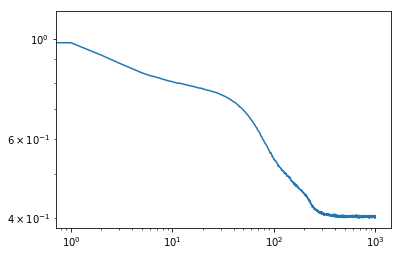

In [16]:
plot(losses[1:])
plt.yscale('log')
plt.xscale('log')
plt.show()


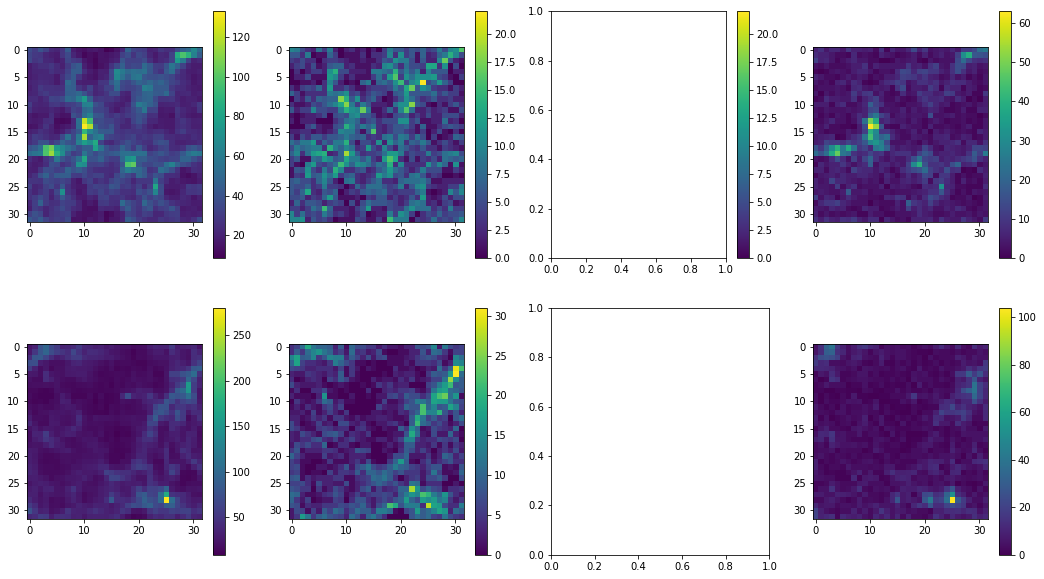

In [17]:


fig, ax = plt.subplots(2, 4, figsize = (18, 10))
ii = 0
axis = ax[0]
im = axis[0].imshow(fins[ii].sum(axis=0))
colorbar(im, ax=axis[0])
im = axis[1].imshow(finsample[ii].sum(axis=0))
colorbar(im, ax=axis[1])
# im = axis[2].imshow(learnfin[ii].sum(axis=0))
colorbar(im, ax=axis[2])
im = axis[3].imshow(learnspecfin[ii].sum(axis=0))
colorbar(im, ax=axis[3])
ii = 900
axis = ax[1]
im = axis[0].imshow(fins[ii].sum(axis=0))
colorbar(im, ax=axis[0])
im = axis[1].imshow(finsample[ii].sum(axis=0))
colorbar(im, ax=axis[1])
# im = axis[2].imshow(learnfin[ii].sum(axis=0))
# colorbar(im, ax=axis[2])
im = axis[3].imshow(learnspecfin[ii].sum(axis=0))
colorbar(im, ax=axis[3])



In [18]:
%%bash
ls ./modules/
# rm -r ./modules/specdensemoduleza3dsamplefin


densemodule
densemoduleza
densemoduleza2d
densemoduleza2dsample
densemoduleza3dsample
densemoduleza3dsamplefin
densemoduleza3dsamplefingrad
densemodulezanormal
densemodulezapoisson
fwdmodel
fwdmodelza2d
specdensemodule
specdensemoduleza
specdensemoduleza2d
specdensemoduleza2dsample
specdensemoduleza3dsample
specdensemoduleza3dsamplefin
specdensemodulezanormal
specdensemodulezapoisson
testspecnorm
testspecnormfalse
testvanillanorm


In [185]:
# module.export('./modules/specdensemoduleza3dsamplefin', sess)


INFO:tensorflow:Exported TF-Hub module to: ./modules/specdensemoduleza3dsamplefin


INFO:tensorflow:Exported TF-Hub module to: ./modules/specdensemoduleza3dsamplefin


In [192]:
# tf.reset_default_graph()
# modname = './modules/specdensemoduleza3dsamplefin///'
# module = hub.Module(modname, trainable=False)
# sample = module({'features':fins, 'labels':finsample}, as_dict=True)['sample']
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     learnspecfin = sess.run(sample)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [19]:
ii = 1
kk, p1 = tools.power(finsample[ii], boxsize=bs)
kk, p2 = tools.power(learnfin[ii], boxsize=bs)
kk, p5 = tools.power(learnspecfin[ii], boxsize=bs)
kk, p12 = tools.power(finsample[ii], learnfin[ii], boxsize=bs)
kk, p15 = tools.power(finsample[ii], learnspecfin[ii], boxsize=bs)

plt.plot(kk, p12/(p1*p2)**.5, 'r-', label='Learn Final')
plt.plot(kk, p15/(p1*p5)**.5, 'c-', label='Learn Spec Final')
plt.xscale('log')
plt.grid()

NameError: name 'learnfin' is not defined

## recon again

In [190]:
tf.reset_default_graph()
modname = './modules/specdensemoduleza3dsamplefin/'
xreconsspecfin = []
losses = []
priors = []
xinit = []

nstart = 1

ir = [900]
for ii in ir:
#     ii = 2*i
    np.random.seed(100)
    yy = np.array([finsample[ii].copy() for j in range(nstart)])
    yy = yy
    xi = 1*randn( nc, nc, nc)
    xi = xi.astype('float32')

    recons = doreconfin(yy, xi, modname, useprior=True, niter=3000, lr=0.01)
    xrecon = np.squeeze(recons[0])
#     recons = doreconfin(yy, xrecon, modname, useprior=True, niter=3000, lr=0.005)
    xreconsspecfin.append(xrecon)
    losses.append(np.squeeze(recons[1]))
    priors.append(np.squeeze(recons[2]))
    xinit.append(xi)



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Tensor("Neg:0", shape=(1,), dtype=float32) Tensor("prior:0", shape=(), dtype=float32)
0 17341.865


KeyboardInterrupt: 

In [ ]:
plt.plot(losses[0])

In [157]:
np.save('./xreconfinspecdenseza3dsample', xreconsspecfin[0])
# xreconsspecfin = [np.load('./xreconfinspecdenseza3dsample.npy')]

In [158]:
modname = './modules/specdensemoduleza3dsamplefin/'
# samplexreconsspecfin = doreconfin(np.expand_dims(xreconsspecfin[0], 0)*0, 
#                                xreconsspecfin[0], modname=modname, sampleonly=True)

tmp = inits[ir[0]].copy()
samplelearnspecfin = doreconfin(np.expand_dims(tmp, 0)*0, tmp , modname=modname, sampleonly=True)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


## Compare recon

In [160]:

finalxrecons = evolvefinal(xrecons[0][0])
finalxreconsfin = evolvefinal(xreconsfin[0])
finalxreconsspec = evolvefinal(xreconsspec[0][0])
finalxreconsspecfin = evolvefinal(xreconsspecfin[0])

In [161]:
truth = lins[ir[0]]
data = finsample[ir[0]]

In [174]:
# fig, ax = plt.subplots(1, 5, figsize = (16, 4))
# ax[0].imshow(truth.sum(axis=0))
# ax[0].set_title('Truth')
# ax[1].imshow(xrecons[0].mean(axis=0).sum(axis=0))
# ax[1].set_title('Mean Recon Vanilla')
# ax[2].imshow(xreconsspec[0].mean(axis=0).sum(axis=0))
# ax[2].set_title('Mean Recon Spec')
# ax[3].imshow(xreconsfin[0].sum(axis=0))
# ax[3].set_title('Recon from final network')
# ax[4].imshow(xreconsspecfin[0].sum(axis=0))
# ax[4].set_title('Recon from final network')


Text(0.5, 1.0, 'PM + Spec Norm')

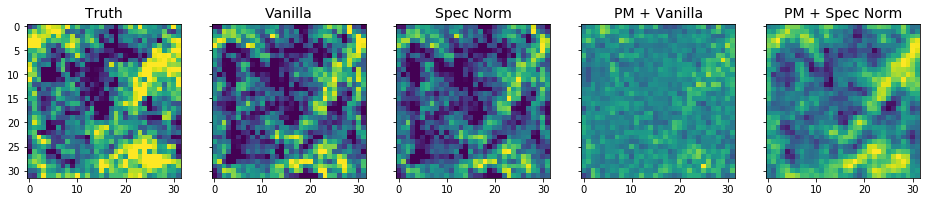

In [175]:
vmin = -30 
vmax = 30

fig, ax = plt.subplots(1, 5, figsize = (16, 5), sharex=True, sharey=True)
fsize = 14
ax[0].imshow(truth.sum(axis=0), vmin=vmin, vmax=vmax)
ax[0].set_title('Truth', fontsize=fsize)
ax[1].imshow(xrecons[0][0].sum(axis=0), vmin=vmin, vmax=vmax)
ax[1].set_title('Vanilla', fontsize=fsize)
ax[2].imshow(xreconsspec[0][0].sum(axis=0), vmin=vmin, vmax=vmax)
ax[2].set_title('Spec Norm', fontsize=fsize)
ax[3].imshow(xreconsfin[0].sum(axis=0), vmin=vmin, vmax=vmax)
ax[3].set_title('PM + Vanilla', fontsize=fsize)
ax[4].imshow(xreconsspecfin[0].sum(axis=0), vmin=vmin, vmax=vmax)
ax[4].set_title('PM + Spec Norm', fontsize=fsize)


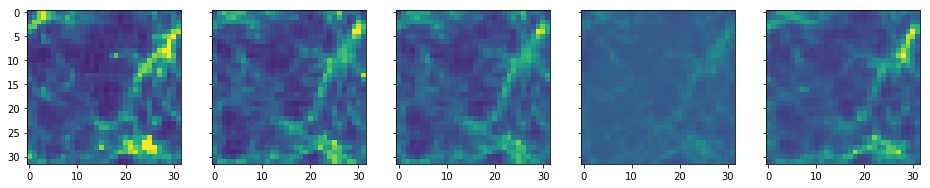

In [164]:
vmax = 100
fsize = 14
fig, ax = plt.subplots(1, 5, figsize = (16, 5), sharex=True, sharey=True)

im = ax[0].imshow(fins[ir[0]].sum(axis=0), vmin=0, vmax=vmax)
# ax[0].set_title('Truth', fontsize=fsize)
# plt.colorbar(im)
ax[1].imshow(finalxrecons.sum(axis=0), vmin=0, vmax=vmax)
# ax[1].set_title('Vanilla', fontsize=fsize)
ax[2].imshow(finalxreconsspec.sum(axis=0), vmin=0, vmax=vmax)
# ax[2].set_title('Spec Norm', fontsize=fsize)
ax[3].imshow(finalxreconsfin.sum(axis=0), vmin=0, vmax=vmax)
# ax[3].set_title('PM + Vanilla', fontsize=fsize)
ax[4].imshow(finalxreconsspecfin.sum(axis=0), vmin=0, vmax=vmax)
# ax[4].set_title('PM + Spec Norm', fontsize=fsize)


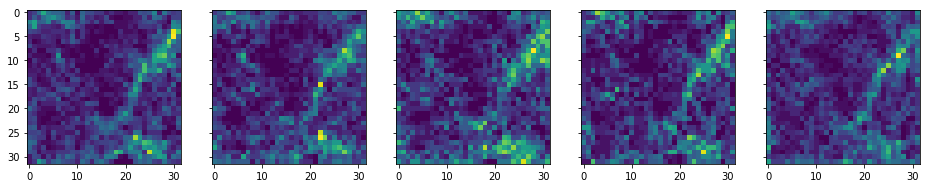

In [165]:
fig, ax = plt.subplots(1, 5, figsize = (16, 5), sharex=True, sharey=True)
ax[0].imshow(data.sum(axis=0))
# ax[0].set_title('Truth')
ax[1].imshow(samplexrecons[0].sum(axis=0))
# ax[1].set_title('Single Recon Vanilla')
ax[2].imshow(samplexreconsspec[0].sum(axis=0))
# ax[2].set_title('Single Recon Spec')
ax[3].imshow(samplexreconsfin.sum(axis=0))
# ax[3].set_title('Recon from final network')
ax[4].imshow(samplexreconsspecfin.sum(axis=0))
# ax[4].set_title('Recon from final network')


In [176]:
# kk, p1 = tools.power(truth+1, boxsize=bs)
# kk, p2 = tools.power(xrecons[0][0]+1, boxsize=bs)
# kk, p3 = tools.power(xreconsspec[0][0]+1, boxsize=bs)
# kk, p12 = tools.power(truth+1, xrecons[0][0]+1, boxsize=bs)
# kk, p13 = tools.power(truth+1, xreconsspec[0][0]+1, boxsize=bs)

# kk, p2all = tools.power(xrecons[0].mean(axis=0)+1, boxsize=bs)
# kk, p3all = tools.power(xreconsspec[0].mean(axis=0)+1, boxsize=bs)
# kk, p12all = tools.power(truth+1, xrecons[0].mean(axis=0)+1, boxsize=bs)
# kk, p13all = tools.power(truth+1, xreconsspec[0].mean(axis=0)+1, boxsize=bs)

# plt.plot(kk, p12/(p1*p2)**.5, 'r', label='Vanilla recon Single')
# plt.plot(kk, p13/(p1*p3)**.5, 'b', label='Spec recon Single')

# plt.plot(kk, p12all/(p1*p2all)**.5, 'g--', label='Vanilla recon Mean')
# plt.plot(kk, p13all/(p1*p3all)**.5, 'c--', label='Spec recon Mean')

# ii = 1
# kk, p1 = tools.power(finsample[ii], boxsize=bs)
# kk, p2 = tools.power(samplelearn, boxsize=bs)
# kk, p3 = tools.power(samplelearnspec, boxsize=bs)
# kk, p4 = tools.power(samplelearnfin, boxsize=bs)
# kk, p12 = tools.power(finsample[ii], samplelearn, boxsize=bs)
# kk, p13 = tools.power(finsample[ii], samplelearnspec, boxsize=bs)
# kk, p14 = tools.power(finsample[ii], samplelearnfin, boxsize=bs)

# # plt.plot(kk, p12/(p1*p2)**.5, 'k', label='samplelearn Vanilla')
# # plt.plot(kk, p13/(p1*p3)**.5, 'k--', label='samplelearn Spec')
# # plt.plot(kk, p14/(p1*p4)**.5, 'k:', label='samplelearn Vanilla Fin')


# plt.xscale('log')
# plt.xlabel('k (h/Mpc)', fontsize=13)
# plt.ylabel('r$_c$', fontsize=13)
# plt.legend(fontsize=13)

# plt.suptitle('Compare mean recon vs single recon')

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


Text(0.5, 1.0, 'Correlation compare for train and recon linear')

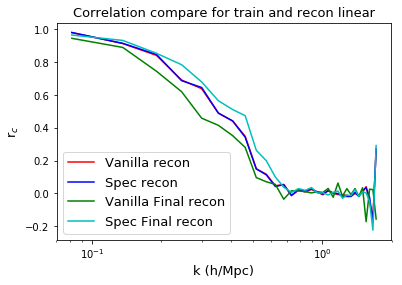

In [177]:
kk, p1 = tools.power(truth+1, boxsize=bs)
kk, p2 = tools.power(xrecons[0][0]+1, boxsize=bs)
kk, p3 = tools.power(xreconsspec[0][0]+1, boxsize=bs)
kk, p4 = tools.power(xreconsfin[0]+1, boxsize=bs)
kk, p5 = tools.power(xreconsspecfin[0]+1, boxsize=bs)

kk, p12 = tools.power(truth+1, xrecons[0][0]+1, boxsize=bs)
kk, p13 = tools.power(truth+1, xreconsspec[0][0]+1, boxsize=bs)
kk, p14 = tools.power(truth+1, xreconsfin[0]+1, boxsize=bs)
kk, p15 = tools.power(truth+1, xreconsspecfin[0]+1, boxsize=bs)

plt.plot(kk, p12/(p1*p2)**.5, 'r', label='Vanilla recon')
plt.plot(kk, p13/(p1*p3)**.5, 'b', label='Spec recon')
plt.plot(kk, p14/(p1*p4)**.5, 'g', label='Vanilla Final recon')
plt.plot(kk, p15/(p1*p5)**.5, 'c', label='Spec Final recon')


ii = 1
kk, p1 = tools.power(finsample[ii], boxsize=bs)
kk, p2 = tools.power(samplelearn, boxsize=bs)
kk, p3 = tools.power(samplelearnspec, boxsize=bs)
kk, p4 = tools.power(samplelearnfin, boxsize=bs)
kk, p12 = tools.power(finsample[ii], samplelearn, boxsize=bs)
kk, p13 = tools.power(finsample[ii], samplelearnspec, boxsize=bs)
kk, p14 = tools.power(finsample[ii], samplelearnfin, boxsize=bs)

# plt.plot(kk, p12/(p1*p2)**.5, 'r--', label='Learn Vanilla')
# plt.plot(kk, p13/(p1*p3)**.5, 'b--', label='Learn Spec')
# plt.plot(kk, p14/(p1*p4)**.5, 'g--', label='Learn Vanilla Fin')


plt.xscale('log')
plt.xlabel('k (h/Mpc)', fontsize=13)
plt.ylabel('r$_c$', fontsize=13)
plt.legend(fontsize=13)
plt.title('Correlation compare for train and recon linear', fontsize=13)


/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/home/chmodi/.

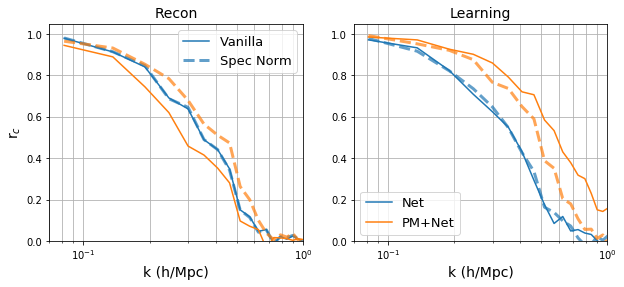

In [168]:
plt.figure(figsize = (10, 4))
ii = ir[0]
kk, p1 = tools.power(truth+1, boxsize=bs)
kk, p2 = tools.power(xrecons[0][0]+1, boxsize=bs)
kk, p3 = tools.power(xreconsspec[0][0]+1, boxsize=bs)
kk, p4 = tools.power(xreconsfin[0]+1, boxsize=bs)
kk, p5 = tools.power(xreconsspecfin[0]+1, boxsize=bs)

kk, p12 = tools.power(truth+1, xrecons[0][0]+1, boxsize=bs)
kk, p13 = tools.power(truth+1, xreconsspec[0][0]+1, boxsize=bs)
kk, p14 = tools.power(truth+1, xreconsfin[0]+1, boxsize=bs)
kk, p15 = tools.power(truth+1, xreconsspecfin[0]+1, boxsize=bs)

ax1 = plt.subplot(1, 2, 1)
plt.plot(kk, p12/(p1*p2)**.5, 'C0', label='Vanilla', lw=1.5)
plt.plot(kk, p13/(p1*p3)**.5, 'C0--', label='Spec Norm', lw=3, alpha=0.7)
plt.plot(kk, p14/(p1*p4)**.5, 'C1', label='', lw=1.5)
plt.plot(kk, p15/(p1*p5)**.5, 'C1--', label='', lw=3, alpha=0.7)

kk, p1 = tools.power(finsample[ii], boxsize=bs)
kk, p2 = tools.power(samplelearn, boxsize=bs)
kk, p3 = tools.power(samplelearnspec, boxsize=bs)
kk, p4 = tools.power(samplelearnfin, boxsize=bs)
kk, p5 = tools.power(samplelearnspecfin, boxsize=bs)
kk, p12 = tools.power(finsample[ii], samplelearn, boxsize=bs)
kk, p13 = tools.power(finsample[ii], samplelearnspec, boxsize=bs)
kk, p14 = tools.power(finsample[ii], samplelearnfin, boxsize=bs)
kk, p15 = tools.power(finsample[ii], samplelearnspecfin, boxsize=bs)

ax2 = plt.subplot(1, 2, 2)
plt.plot(kk, p12/(p1*p2)**.5, 'C0', label='Net', lw=1.5)
plt.plot(kk, p13/(p1*p3)**.5, 'C0--', label='', lw=3, alpha=0.7)
plt.plot(kk, p14/(p1*p4)**.5, 'C1', label='PM+Net', lw=1.5)
plt.plot(kk, p15/(p1*p5)**.5, 'C1--', label='', lw=3, alpha=0.7)


for axis in [ax1, ax2]:
    axis.set_xscale('log')
    axis.set_xlabel('k (h/Mpc)', fontsize=14)
    axis.set_ylim(0, 1.05)
    axis.grid(which='both')
    axis.set_xlim(0.07, 1)
    axis.legend(fontsize=13)

ax1.set_ylabel('r$_c$', fontsize=14)
ax1.set_title('Recon', fontsize=14)
ax2.set_title('Learning', fontsize=14)
plt.show()

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/chmod

Text(0, 0.5, 'r$_c$')

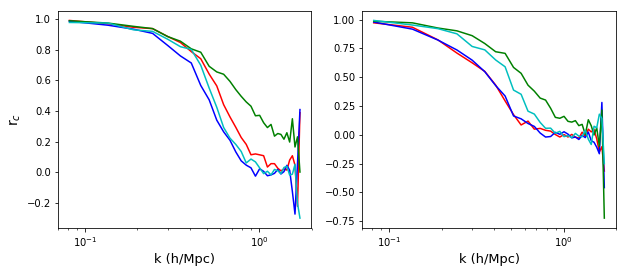

In [169]:
plt.figure(figsize = (10, 4))
ii = ir[0]
kk, p1 = tools.power(finsample[ii], boxsize=bs)
kk, p2 = tools.power(samplexrecons[0], boxsize=bs)
kk, p3 = tools.power(samplexreconsspec[0], boxsize=bs)
kk, p4 = tools.power(samplexreconsfin, boxsize=bs)
kk, p5 = tools.power(samplexreconsspecfin, boxsize=bs)
kk, p12 = tools.power(finsample[ii], samplexrecons[0], boxsize=bs)
kk, p13 = tools.power(finsample[ii], samplexreconsspec[0], boxsize=bs)
kk, p14 = tools.power(finsample[ii], samplexreconsfin, boxsize=bs)
kk, p15 = tools.power(finsample[ii], samplexreconsspecfin, boxsize=bs)

ax1 = plt.subplot(1, 2, 1)
plt.plot(kk, p12/(p1*p2)**.5, 'r', label='Vanilla recon')
plt.plot(kk, p13/(p1*p3)**.5, 'b', label='Spec recon')
plt.plot(kk, p14/(p1*p4)**.5, 'g', label='Vanilla Final recon')
plt.plot(kk, p15/(p1*p5)**.5, 'c', label='Spec Final recon')

kk, p1 = tools.power(finsample[ii], boxsize=bs)
kk, p2 = tools.power(samplelearn, boxsize=bs)
kk, p3 = tools.power(samplelearnspec, boxsize=bs)
kk, p4 = tools.power(samplelearnfin, boxsize=bs)
kk, p5 = tools.power(samplelearnspecfin, boxsize=bs)
kk, p12 = tools.power(finsample[ii], samplelearn, boxsize=bs)
kk, p13 = tools.power(finsample[ii], samplelearnspec, boxsize=bs)
kk, p14 = tools.power(finsample[ii], samplelearnfin, boxsize=bs)
kk, p15 = tools.power(finsample[ii], samplelearnspecfin, boxsize=bs)

ax2 = plt.subplot(1, 2, 2)
plt.plot(kk, p12/(p1*p2)**.5, 'r-', label='Learn Vanilla')
plt.plot(kk, p13/(p1*p3)**.5, 'b-', label='Learn Spec')
plt.plot(kk, p14/(p1*p4)**.5, 'g-', label='Learn Vanilla Final')
plt.plot(kk, p15/(p1*p5)**.5, 'c-', label='Learn Spec Final')


for axis in [ax1, ax2]:
    axis.set_xscale('log')
    axis.set_xlabel('k (h/Mpc)', fontsize=13)
ax1.set_ylabel('r$_c$', fontsize=14)
# plt.legend(fontsize=13)


# Reconpm

In [159]:
kmesh = sum(kk**2 for kk in config['kvec'])**0.5
priorwt = config['ipklin'](kmesh) * config['boxsize'] ** -3

def doreconpm(yy, xinit, useprior=True, niter=5000, lr=0.001, sampleonly=False):
    tf.reset_default_graph()
    

    xrecon = tf.get_variable('xrecon',
                             initializer=xinit, 
                             trainable=True)

    icstate = tfpm.lptinit(xrecon, config, name='icstate')
    fnstate = tfpm.nbody(icstate, config, verbose=False, name='fnstate')
    final = tf.zeros_like(xrecon)
    final = tfpf.cic_paint(final, fnstate[0], boxsize=config['boxsize'], name='final')

    loglik = tf.nn.l2_loss(final - yy)

    xreconk = tfpmfuncs.r2c3d(xrecon)
    priormesh = tf.square(tf.cast(tf.abs(xreconk), tf.float32))
    prior = tf.reduce_sum(tf.multiply(priormesh, 1/priorwt), axis=(0, 1, 2))
    prior = tf.multiply(prior, 1/nc, name='prior')
    print(loglik, prior)

    if useprior: loss = tf.add(loglik, prior)
    else: loss = loglik
#   
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
    opt_op = optimizer.minimize(loss, var_list=[xrecon])


    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        xinit = sess.run(xrecon)
        losses = []
        priors = []
        for it in range(niter+1):
            _, l, p = sess.run([opt_op, loss, prior])
            if it%300==0: print(it, l[0])
            losses.append(l)
            priors.append(p)
        xfin = sess.run(xrecon)
        
    return xfin, losses, priors

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  """Entry point for launching an IPython kernel.


In [ ]:
tf.reset_default_graph()
xreconspm = []
losses = []
priors = []
xinit = []

nstart = 1

ir = [900]
for ii in ir:
#     ii = 2*i
    np.random.seed(100)
    yy = np.array([fins[ii].copy() for j in range(nstart)])
    yy = yy
    xi = 1*randn( nc, nc, nc)
    xi = xi.astype('float32')

    recons = doreconpm(yy, xi, modname, useprior=True, niter=2000, lr=0.01)
    xreconspm.append(xrecon)
    losses.append(np.squeeze(recons[1]))
    priors.append(np.squeeze(recons[2]))
    xinit.append(xi)



# recon from final with Fourier loss

In [136]:
inits[0].mean(), fins[0].mean()

(-0.0005439408, 1.0)

In [224]:
np.unique(sids)

array([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32])

In [245]:
tones


<tf.Tensor 'ones_like_10:0' shape=(5,) dtype=float32>

In [269]:
tf.reset_default_graph()
mc = np.array((1, 2, 3, 4, 5))
sids = np.array((3, 3, 6, 1, 1)).astype(int)
nbins = sids.max() + 1
tones = tf.ones_like(mc, dtype=tf.float32)
tx = tf.real(tf.unsorted_segment_sum(mc, sids, nbins))
tc = tf.real(tf.unsorted_segment_sum(tones, sids, nbins))

with tf.Session() as sess:
    cross = sess.run(tx)
    count = sess.run(tc)

print(cross, count)

[0 9 0 3 0 0 3] [0. 2. 0. 2. 0. 0. 1.]


In [326]:
_, edges = numpy.histogram(kmesh.flat, bins=nc)
# center= 0.5*(edges[1:] + edges[:-1])
# bins = center.copy()
bins = edges.copy()
sids = np.digitize(kmesh, bins, right=False)
print(sids.min(), sids.max())
bin_means = np.array([kmesh[sids == i].sum() for i in range(sids.min(), sids.max())])
# bin_means = np.array([kmesh[sids == i].sum() for i in range(1, len(sids))])


1 33


In [327]:
bin_means

array([0.00000000e+00, 1.44328308e+00, 8.69025993e+00, 1.75574036e+01,
       4.20024490e+01, 7.40902786e+01, 1.19656631e+02, 1.75458466e+02,
       2.65796539e+02, 4.05849060e+02, 5.59275574e+02, 6.29710571e+02,
       9.09700073e+02, 1.05002380e+03, 1.28888086e+03, 1.66096729e+03,
       2.00318115e+03, 2.36894971e+03, 2.89988721e+03, 2.67701489e+03,
       2.68637305e+03, 2.46941211e+03, 2.43266699e+03, 2.04055042e+03,
       1.68907129e+03, 1.27475903e+03, 8.94936951e+02, 4.20978760e+02,
       3.83145599e+02, 1.15106766e+02, 9.21982651e+01, 1.02344580e+01],
      dtype=float32)

In [328]:
bin_means2, edges = numpy.histogram(kmesh.flat, bins=nc, weights=kmesh.flat)


In [329]:
bin_means2/bin_means

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([       nan, 1.        , 1.0000001 , 1.0000001 , 1.        ,
       1.        , 1.        , 1.        , 1.0000001 , 0.99999994,
       1.0000001 , 0.9999999 , 1.0000001 , 1.        , 1.        ,
       1.        , 1.        , 1.0000001 , 1.        , 1.        ,
       1.0000001 , 1.0000001 , 1.        , 1.0000001 , 1.        ,
       0.9999999 , 1.        , 1.        , 1.0000001 , 1.0000001 ,
       0.99999994, 1.1701359 ], dtype=float32)

In [386]:
def tfpower(f1, f2=None, boxsize=1.0, kmesh=None, symmetric=False):
    nbins = f1.shape[0]
    if kmesh is None:
        k = fftk(f1.shape, boxsize, symmetric=symmetric)
        kmesh = sum(kk**2 for kk in k)**0.5
    _, edges = numpy.histogram(kmesh.flat, bins=nbins)
    bins = edges.copy()
    sids = np.digitize(kmesh, bins, right=False)

    f1c = tfpf.r2c3d(f1)
    if f2 is None:
        f2c = tfpf.r2c3d(f1)
    else:f2c = tfpf.r2c3d(f2)
    ff = tf.multiply(f1c, tf.conj(f2c))
    tk = tf.constant(kmesh)
    ones = tf.ones_like(ff, dtype=tf.float32)
    cc = tf.real(tf.unsorted_segment_sum(ones, sids, sids.max()))[sids.min():sids.max()]
    kk = tf.real(tf.unsorted_segment_sum(kmesh, sids, sids.max()))[sids.min():sids.max()]
    pp = tf.real(tf.unsorted_segment_sum(ff, sids, sids.max()))[sids.min():sids.max()]
    
    pp = tf.multiply(pp, 1./cc) * boxsize**3
    kk = tf.multiply(kk, 1./cc)
    return kk, pp


In [399]:
tf.reset_default_graph()

m = tf.constant(inits[0]+1)
tkkx, tppx = tfpower(m, fins[0], bs, kmesh)
tkk1, tpp1 = tfpower(m, boxsize=bs, kmesh=kmesh)
tkk2, tpp2 = tfpower(fins[0], boxsize=bs, kmesh=kmesh)
gp = tf.gradients(tppx, m)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    px, p1, p2 = sess.run([ tppx, tpp1, tpp2])
    kx, k1, k2 = sess.run([ tkkx, tkk1, tkk2])
    grad = sess.run(gp)
    
kp, p1p = tools.power(inits[0]+1, boxsize=bs)
kp, p2p = tools.power(fins[0], boxsize=bs)
kp, pxp = tools.power(inits[0]+1, fins[0], boxsize=bs)

In [403]:
grad[1].shape

IndexError: list index out of range

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


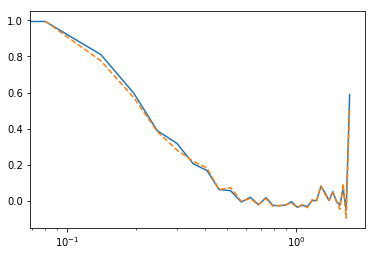

In [395]:
plt.plot(k, px**1/(p1*p2)**0.5)
plt.plot(k, pxp**1/(p1p*p2p)**0.5, '--')
plt.xscale('log')

In [343]:
# _, edges = numpy.histogram(kmesh.flat, bins=nc)
# bins = edges.copy()
# sids = np.digitize(kmesh, bins, right=False)
# print(sids.min(), sids.max())

# m1 = tfpf.r2c3d(inits[0]+1)
# m2 = tfpf.r2c3d(fins[0])
# mc = tf.multiply(m1, tf.conj(m2))
# tk = tf.constant(kmesh)
# tones = tf.ones_like(mc, dtype=tf.float32)
# tx = tf.real(tf.unsorted_segment_sum(mc, sids, sids.max()))[sids.min():sids.max()]
# tc = tf.real(tf.unsorted_segment_sum(tones, sids, sids.max()))[sids.min():sids.max()]
# tk = tf.real(tf.unsorted_segment_sum(kmesh, sids, sids.max()))[sids.min():sids.max()]

# with tf.Session() as sess:
#     mesh = sess.run(mc)
#     cross = sess.run(tx)
#     count = sess.run(tc)
#     kvals = sess.run(tk)
# kvals/= count
# cross/= count

1 33


In [347]:
H, edges = numpy.histogram(kmesh.flat, weights=mesh.flat, bins=mesh.shape[0])
N, edges = numpy.histogram(kmesh.flat, bins=edges)
center= 0.5*(edges[1:] + edges[:-1])

# print(0.5*center)
# print(H * bs**3/N)


In [349]:
N/ count

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.16666667])

/home/chmodi/.local/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


[]

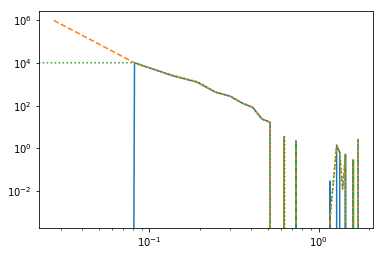

In [352]:
plt.plot(*tools.power(inits[0]+1, fins[0], boxsize=bs, symmetric=False))
plt.plot(center, H*bs**3/N, '--')
plt.plot(kvals, cross*bs**3, ':')

plt.loglog()

In [192]:
cross.size

33

In [ ]:
kmesh = sum(kk**2 for kk in config['kvec'])**0.5
priorwt = config['ipklin'](kmesh) * config['boxsize'] ** -3

def doreconfin(yy, xinit, modname, useprior=True, niter=5000, lr=0.001, sampleonly=False):
    tf.reset_default_graph()
    module = hub.Module(modname, trainable=False)

    xrecon = tf.get_variable('xrecon',
                             initializer=xinit, 
                             trainable=True)

    icstate = tfpm.lptinit(xrecon, config, name='icstate')
    fnstate = tfpm.nbody(icstate, config, verbose=False, name='fnstate')
    final = tf.zeros_like(xrecon)
    final = tfpf.cic_paint(final, fnstate[0], boxsize=config['boxsize'], name='final')

    sample = module({'features':tf.expand_dims(final, 0), 'labels':yy}, as_dict=True)['sample']
    rate = module({'features':tf.expand_dims(final, 0), 'labels':yy}, as_dict=True)['rate']
    if sampleonly: 
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            sample = sess.run(sample)
        return sample
    
        
    loglik = module({'features':tf.expand_dims(final, 0), 'labels':yy}, as_dict=True)['loglikelihood']
    loglik = -tf.reduce_sum(loglik, axis=(1, 2, 3))
    
    ratek = tfpmfuncs.r2c3d(rate)
    datak = tfpmfuncs.r2c3d(data)
    
    
    xreconk = tfpmfuncs.r2c3d(xrecon)
    priormesh = tf.square(tf.cast(tf.abs(xreconk), tf.float32))
    prior = tf.reduce_sum(tf.multiply(priormesh, 1/priorwt), axis=(0, 1, 2))
    prior = tf.multiply(prior, 1/nc, name='prior')
    print(loglik, prior)

    if useprior: loss = tf.add(loglik, prior)
    else: loss = loglik
#   
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
    opt_op = optimizer.minimize(loss, var_list=[xrecon])


    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        xinit = sess.run(xrecon)
        losses = []
        priors = []
        for it in range(niter+1):
            _, l, p = sess.run([opt_op, loss, prior])
            if it%300==0: print(l[0])
            losses.append(l)
            priors.append(p)
        xfin = sess.run(xrecon)
        
    return xfin, losses, priors

In [80]:
tf.reset_default_graph()
modname = './modules/densemoduleza3dsamplefin////'
module = hub.Module(modname, trainable=False)
rate = module({'features':fins[ir[0]:ir[0]+1], 'labels':finsample[ir[0]:ir[0]+1]}, as_dict=True)['rate']
sample = module({'features':fins[ir[0]:ir[0]+1], 'labels':finsample[ir[0]:ir[0]+1]}, as_dict=True)['sample']
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    learn = sess.run(sample)
    learnrate = sess.run(rate)
#     learn = sess.run(sample, feed_dict={xx:inits, yy:finsample})



INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


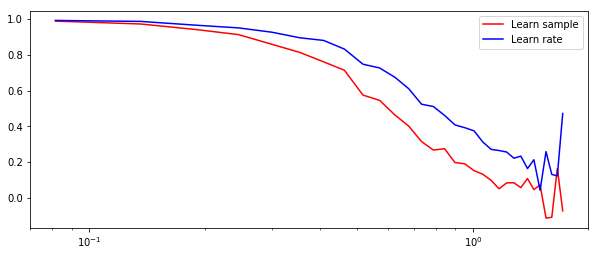

In [88]:
plt.figure(figsize = (10, 4))
ii = ir[0]

kk, p1 = tools.power(finsample[ii], boxsize=bs)
kk, p2 = tools.power(learn, boxsize=bs)
kk, p3 = tools.power(learnrate, boxsize=bs)
kk, p12 = tools.power(finsample[ii], learn, boxsize=bs)
kk, p13 = tools.power(finsample[ii], learnrate, boxsize=bs)

# ax2 = plt.subplot(1, 2, 2)
plt.plot(kk, p12/(p1*p2)**.5, 'r-', label='Learn sample')
plt.plot(kk, p13/(p1*p3)**.5, 'b-', label='Learn rate')
# plt.plot(kk, p14/(p1*p4)**.5, 'g-', label='Learn Vanilla Final')
# plt.plot(kk, p15/(p1*p5)**.5, 'c-', label='Learn Spec Final')
plt.xscale('log')
plt.legend()

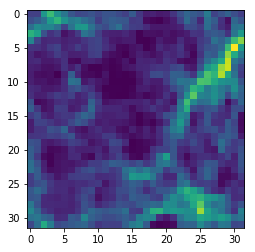

In [83]:
plt.imshow(learnrate.sum(axis=0))

# Train fixed point network

In [16]:

tf.reset_default_graph()


nfilter = 16
def module_fn():
    '''Define network here'''
    x = tf.placeholder(tf.float32, shape=[None, nc, nc, nc], name='input')
    y = tf.placeholder(tf.float32, shape=[None, nc, nc, nc], name='output')

    reg = tf.contrib.layers.l2_regularizer(0.00)

    xx = tf.expand_dims(x, -1)
    net = tf.layers.conv3d(xx,nfilter, 5, activation=tf.nn.leaky_relu, kernel_regularizer=reg,padding='same')
    
    net = tf.nn.leaky_relu(net)
    subnet = tf.layers.conv3d(net,nfilter, 3, kernel_regularizer=reg,padding='same')
    net = net + tf.layers.conv3d(subnet,nfilter, 3, kernel_regularizer=reg,padding='same')
    net = tf.nn.dropout(net, 0.95)

    net = tf.nn.leaky_relu(net)
    subnet = tf.layers.conv3d(net,nfilter, 3, kernel_regularizer=reg,padding='same')
    net = net + tf.layers.conv3d(subnet,nfilter, 3, kernel_regularizer=reg,padding='same')
    net = tf.nn.dropout(net, 0.95)

    net = tf.nn.leaky_relu(net)
    subnet = tf.layers.conv3d(net,nfilter, 3, kernel_regularizer=reg,padding='same')
    net = net + tf.layers.conv3d(subnet,nfilter, 3, kernel_regularizer=reg,padding='same')
    net = tf.nn.dropout(net, 0.95)

    net = tf.nn.leaky_relu(net)
    subnet = tf.layers.conv3d(net,nfilter, 3, kernel_regularizer=reg,padding='same')
    net = net + tf.layers.conv3d(subnet,nfilter, 3, kernel_regularizer=reg,padding='same')
    net = tf.nn.dropout(net, 0.95)

    net = tf.layers.conv3d(net,1, 3, activation=tf.nn.leaky_relu, kernel_regularizer=reg,padding='same')
    net = tf.layers.conv3d(net,1, 1, kernel_regularizer=reg,padding='same')

    lognet = tf.layers.conv3d(net, 1, 1, kernel_regularizer=reg,padding='same', 
                              name='lograte')    
    net = tf.nn.softplus(lognet)
    net= tf.squeeze(net)
    net = tf.identity(net, name='rate')
    mixture_dist = tfd.Poisson(rate=net)
    sample = tf.squeeze(mixture_dist.sample())
#     loglik = mixture_dist.log_prob(tf.expand_dims(y, -1))
    loglik = mixture_dist.log_prob(y)
    
    hub.add_signature(inputs={'features':x, 'labels':y}, 
                        outputs={'sample':sample, 'loglikelihood':loglik, 
                                    'lograte':lognet, 'rate':net})
    
#####                                                                                                                                                                                                                                                                                     


spec = hub.create_module_spec(module_fn)
module = hub.Module(spec, trainable=True)


xx = tf.placeholder(tf.float32, shape=[None, nc, nc, nc], name='input')
yy = tf.placeholder(tf.float32, shape=[None, nc, nc, nc], name='input')
rate = module({'features':xx, 'labels':yy}, as_dict=True)['rate']
loglik = module({'features':xx, 'labels':yy}, as_dict=True)['loglikelihood']
sample = module({'features':xx, 'labels':yy}, as_dict=True)['sample']
# grads = module({'features':xx, 'labels':yy}, as_dict=True)['grads']
loss = -loglik #tf.reduce_sum(tf.square(tf.add(rate, -yy)), axis=-1)
loss = tf.reduce_mean(loss)


gradwt = tf.placeholder(tf.float32, name='gradwt')

grads = tf.gradients(loglik, xx)
print(grads)
gloss = tf.norm(grads)*gradwt
print(gloss)

allloss = loss + gloss

lr = tf.placeholder(tf.float32)
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_op = optimizer.minimize(allloss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
losses =[]

data_size = 800
batch_size = 32

for i in range(200):
    inds = np.random.randint(0, data_size, batch_size)
    x = fins[inds]
    y = finsample[inds]
    l1, l2, l3,_= sess.run([loss, gloss, allloss, train_op], feed_dict={xx:x, yy:y, lr:0.001, gradwt:0})
    l1, l2, l3,_= sess.run([loss, gloss, allloss, train_op], feed_dict={xx:x, yy:y, lr:0.001, gradwt:0})
    l1, l2, l3,_= sess.run([loss, gloss, allloss, train_op], feed_dict={xx:x, yy:y, lr:0.001, gradwt:0.1})
    
    if np.isnan(l3): 
        print(i, l3)
        break
    losses.append(l3)   
    if i%20 ==0: print(i, l1, l2, l3)
# for i in range(500):
#     inds = np.random.randint(0, data_size, batch_size)
#     x = fins[inds]
#     y = finsample[inds]
#     l1, l2, l3,_= sess.run([loss, gloss, allloss, train_op], feed_dict={xx:x, yy:y, lr:0.001, gradwt:0.1})
    
#     if np.isnan(l3): 
#         print(i, l3)
#         break
#     losses.append(l3)   
#     if i%20 ==0: print(i, l1, l2, l3)

# for i in range(1000):
#     inds = np.random.randint(0, data_size, batch_size)
#     x = fins[inds]
#     y = finsample[inds]
#     l1, l2, l3,_= sess.run([loss, gloss, allloss, train_op], feed_dict={xx:x, yy:y, lr:0.0005})
    
#     if np.isnan(l3): 
#         print(i, l3)
#         break
#     losses.append(l3)   
#     if i%20 ==0: print(i, l1, l2, l3)
# for i in range(1000):
#     inds = np.random.randint(0, data_size, batch_size)
#     x = fins[inds]
#     y = finsample[inds]
#     l1, l2, l3,_= sess.run([loss, gloss, allloss, train_op], feed_dict={xx:x, yy:y, lr:0.0001})
    
#     if np.isnan(l3): 
#         print(i, l3)
#         break
#     losses.append(l3)   
#     if i%20 ==0: print(i, l1, l2, l3)


print('Done', l3)
if ~np.isnan(l3):
    learnfingrad = sess.run(sample, feed_dict={xx:fins, yy:y})
    learnfinrategrad = sess.run(rate, feed_dict={xx:fins, yy:y})

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
[<tf.Tensor 'gradients/module_apply_default_1/ExpandDims_grad/Reshape:0' shape=(?, 32, 32, 32) dtype=float32>]
Tensor("mul:0", dtype=float32)
0 0.68444836 26.166782 26.85123
20 0.7448795 1.0593076 1.804187
40 0.7039473 0.65915394 1.3631012
60 0.6521776 0.4540777 1.1062553
80 0.57855684 0.35812888 0.9366857
100 0.51175094 0.30822623 0.81997716
120 0.50609595 0.23530343 0.7413994
140 0.5014787 0.18777232 0.689251
160 0.5033814 0.15760355 0.66098493
180 0.50387913 0.13460569 0.63848484
Done 0.62243557


In [ ]:
# learnfingrad = sess.run(sample, feed_dict={xx:fins, yy:y})
# learnfinrategrad = sess.run(rate, feed_dict={xx:fins, yy:y})

In [ ]:
%%bash
ls modules/
rm -r ./modules/densemoduleza3dsamplefingrad


In [ ]:
module.export('./modules/densemoduleza3dsamplefingrad', sess)


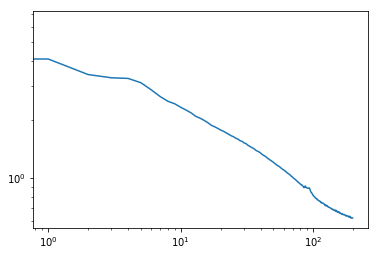

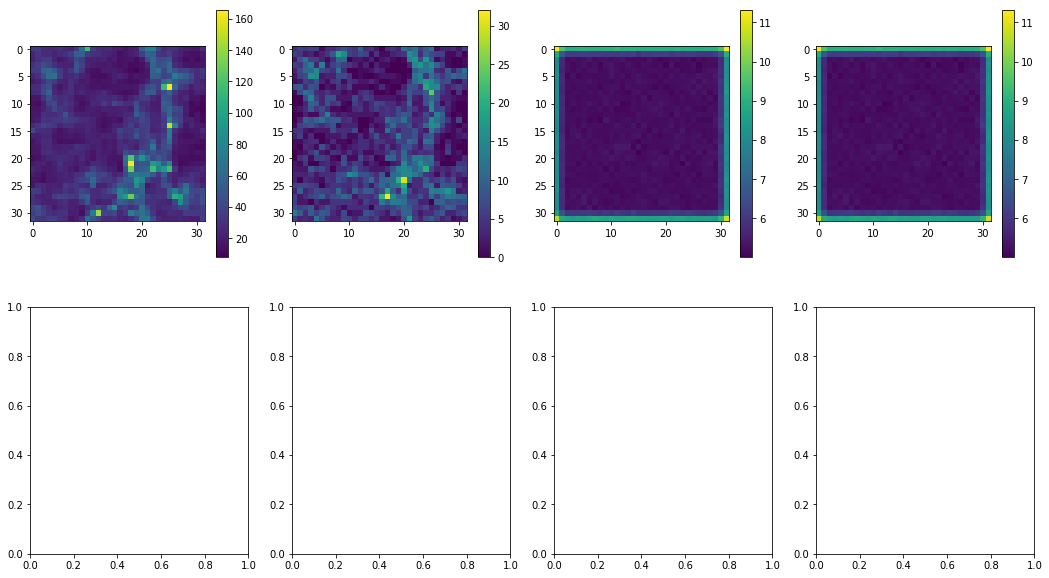

In [17]:
plot(losses[1:])
plt.yscale('log')
plt.xscale('log')
plt.show()


fig, ax = plt.subplots(2, 4, figsize = (18, 10))
ii = 90
axis = ax[0]
im = axis[0].imshow(fins[ii].sum(axis=0))
colorbar(im, ax=axis[0])
im = axis[1].imshow(finsample[ii].sum(axis=0))
colorbar(im, ax=axis[1])
im = axis[2].imshow(learnfinrategrad[ii].sum(axis=0))
colorbar(im, ax=axis[2])
im = axis[3].imshow(learnfinrategrad[ii].sum(axis=0))
colorbar(im, ax=axis[3])
# ii = 900
# axis = ax[1]
# im = axis[0].imshow(fins[ii].sum(axis=0))
# colorbar(im, ax=axis[0])
# im = axis[1].imshow(finsample[ii].sum(axis=0))
# colorbar(im, ax=axis[1])
# im = axis[2].imshow(learn[ii].sum(axis=0))
# colorbar(im, ax=axis[2])
# im = axis[3].imshow(learnfin[ii].sum(axis=0))
# colorbar(im, ax=axis[3])
